In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
import re
from FRVRS import nu
from datetime import timedelta
import matplotlib.pyplot as plt
import re


# OSU dataset of Simulation Sessions, deidentified

Doug screened all of the **VOICE_COMMAND** and **VOICE_CAPTURE** lines and replaced any names with either Max or Jane, regardless of whether the name was that of the responder.

In [3]:

# Get all CSVs into one DataFrame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(149166, 101)


,109766,41008,112471,134769
action_type,TOOL_HOVER,TOOL_HOVER,TOOL_SELECTED,TOOL_HOVER
action_tick,363383,893467,599121,135209
event_time,2023-05-11 10:24:00,2023-03-08 10:53:00,2023-05-11 12:10:00,2023-04-21 11:17:00
session_uuid,c12f8355-5a14-4ccc-bde4-d8038cae9220,89c48e7e-780f-4f1b-a846-fc0f4fd9841c,cc319a3d-a27d-44a2-a594-ff5cecd9ee9a,8b5e760a-1f1a-4a28-bd8f-768bc5f216c6
file_name,c12f8355-5a14-4ccc-bde4-d8038cae9220,Marty24,cc319a3d-a27d-44a2-a594-ff5cecd9ee9a,max13
scene_id,2,2,2,1
tool_hover_type,Tourniquet,Tourniquet,NaN,Tourniquet
tool_hover_count,996,996,NaN,998
tool_selected_type,NaN,NaN,Tourniquet,NaN
tool_selected_count,NaN,NaN,996,NaN


In [4]:

# Explore what types of columns we have
df = nu.get_column_descriptions(frvrs_logs_df).sort_values('count_uniques')
columns_list = ['column_name', 'dtype', 'count_blanks', 'count_uniques', 'count_zeroes', 'min_value', 'max_value']
df[columns_list]

,column_name,dtype,count_blanks,count_uniques,count_zeroes,min_value,max_value
3,voice_capture_command_description,float64,149166,1,0,NaN,NaN
56,patient_engaged_health_level,object,146871,2,0,100,100
54,s_a_l_t_waved_sort_command_text,object,147405,2,0,waved,waved
38,injury_record_injury_treated,object,146114,2,3052,False,False
39,injury_record_injury_treated_with_wrong_treatment,object,146114,2,3052,False,False
...,...,...,...,...,...,...,...
8,teleport_location,object,143488,3423,0,"(-0.1, 0.0, -2.7)","(6.5, 0.0, 2.0)"
4,delta_to_next_action,timedelta64[ns],141112,4039,0,0 days 00:00:00.001000,0 days 00:05:03.311000
41,voice_capture_message,object,139051,5887,0,engine 1712 question,your your scenario is you've been dispatched t...
100,location_id,object,114966,7156,0,"(-0.1, 0.0, -2.7)","(6.5, 0.0, 2.0)"


In [6]:

# Investigate if any sequence is discernable by elapsed time and event time
frvrs_logs_df.sort_values(['action_tick', 'event_time']).tail(4).dropna(axis='columns', how='all').T

,22976,22977,22978,22979
action_type,TELEPORT,VOICE_CAPTURE,TELEPORT,SESSION_END
action_tick,7525382,7525617,7526703,7529672
event_time,2023-05-16 18:20:00,2023-05-16 18:20:00,2023-05-16 18:20:00,2023-05-16 18:20:00
session_uuid,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886
file_name,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886
scene_id,17,17,17,17
teleport_location,"(3.0, 0.0, -2.1)",NaN,"(3.0, 0.0, -1.9)",NaN
voice_capture_message,NaN,and I think that was everyone,NaN,NaN
location_id,"(3.0, 0.0, -2.1)",NaN,"(3.0, 0.0, -1.9)",NaN


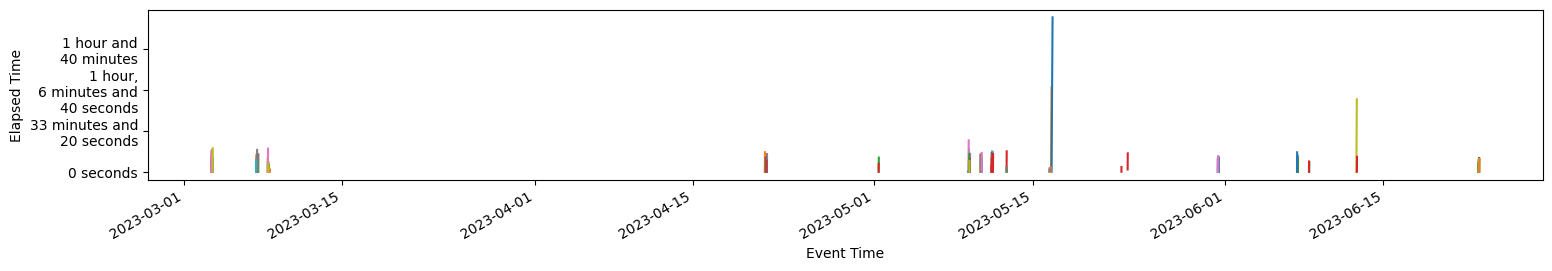

In [7]:

# Visualize the relationship between the event time and the elapsed time
from matplotlib.text import Text
import humanize
from datetime import timedelta

ax = plt.figure(figsize=(18, 2.5)).add_subplot(1, 1, 1)
def f(df):
    try:
        session_uuid = df['session_uuid'].unique().squeeze()
    except:
        session_uuid = df.iloc[0].T.iloc[3]
    df.sort_values(['event_time', 'action_tick']).set_index('event_time').action_tick.plot(ax=ax, label=session_uuid);
    ax.set_yticklabels([
        Text(0, -2000000.0, humanize.precisedelta(timedelta(milliseconds=-2000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(0, 0.0, humanize.precisedelta(timedelta(milliseconds=0.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(0, 2000000.0, humanize.precisedelta(timedelta(milliseconds=2000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(0, 4000000.0, humanize.precisedelta(timedelta(milliseconds=4000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(0, 6000000.0, humanize.precisedelta(timedelta(milliseconds=6000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(0, 8000000.0, humanize.precisedelta(timedelta(milliseconds=8000000.0)).replace(', ', ',\n').replace(' and ', ' and\n'))
    ]);
frvrs_logs_df.groupby('session_uuid').apply(f)
ax.set_xlabel('Event Time')
ax.set_ylabel('Elapsed Time');

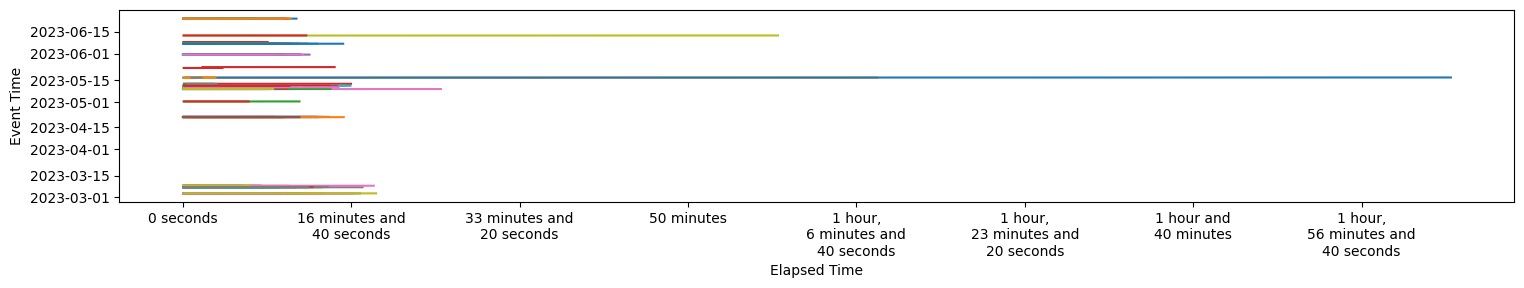

In [8]:

# Visualize the relationship between the elapsed time and the event time
ax = plt.figure(figsize=(18, 2.5)).add_subplot(1, 1, 1)
# tick_labels_set = set()
def f(df):
    try:
        session_uuid = df['session_uuid'].unique().squeeze()
    except:
        session_uuid = df.iloc[0].T.iloc[3]
    df.sort_values(['action_tick', 'event_time']).set_index('action_tick').event_time.plot(ax=ax, label=session_uuid);
    # tick_labels = ax.get_xticklabels()
    # tick_labels_set.add(str(tick_labels))
    ax.set_xticklabels([
        Text(-1000000.0, 0, humanize.precisedelta(timedelta(milliseconds=-1000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(0.0, 0, humanize.precisedelta(timedelta(milliseconds=0.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(1000000.0, 0, humanize.precisedelta(timedelta(milliseconds=1000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(2000000.0, 0, humanize.precisedelta(timedelta(milliseconds=2000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(3000000.0, 0, humanize.precisedelta(timedelta(milliseconds=3000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(4000000.0, 0, humanize.precisedelta(timedelta(milliseconds=4000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(5000000.0, 0, humanize.precisedelta(timedelta(milliseconds=5000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(6000000.0, 0, humanize.precisedelta(timedelta(milliseconds=6000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(7000000.0, 0, humanize.precisedelta(timedelta(milliseconds=7000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(8000000.0, 0, humanize.precisedelta(timedelta(milliseconds=8000000.0)).replace(', ', ',\n').replace(' and ', ' and\n'))
    ]);
frvrs_logs_df.groupby('session_uuid').apply(f)
ax.set_xlabel('Elapsed Time')
ax.set_ylabel('Event Time');

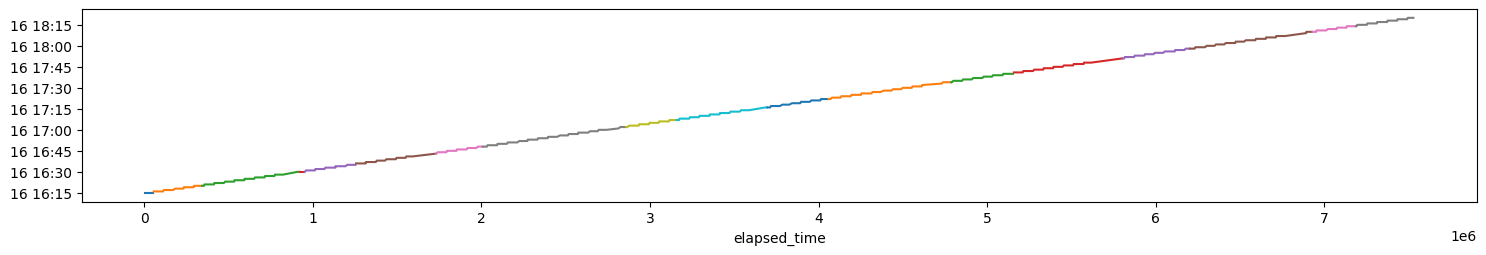

In [9]:

# Get the relationship between the session UUID and the scene
f = lambda df: df.sort_values(['action_tick', 'event_time']).set_index('action_tick').event_time.plot(ax=ax);
session_uuid = frvrs_logs_df.groupby(fu.scene_groupby_columns).count().sort_index(level=1).tail(1).index.get_level_values(0)[0]
mask_series = (frvrs_logs_df.session_uuid == session_uuid)
ax = plt.figure(figsize=(18, 2.5)).add_subplot(1, 1, 1)
_ = frvrs_logs_df[mask_series].groupby('scene_id').apply(f)


## Decision Points

<p>
    OSU and Big Bear: With the IRB approval (for the previous OSU dataset) in place, I would like to get working on the dataset asap. That means:
    <ul>
        <li>Getting it deidentified and sharable</li>
        <li>If there is general demographic information like gender or level of expertise that can be associated with the VR performance, that would be useful.</li>
        <li>Big Bear: once it is available to you, I want an exploratory analysis on decision points such that I can see the variance in responses to the same situation.</li>
        <li>For example, if there are 3 waving patients and the participant chooses to move toward one and assess them, I want to know the sim state (visual info. on each patient, distance, etc.) and then a breakdown of how many participants chose to move toward each patient.</li>
        <li>Similar for treatment options, for each patient present in the simulated environment, what is the variance in which treatment is applied</li>
         <li>Does it depend on ordr?</li>
          <li>Ting?</li>
           <li>Be creative and ask all the questions. The goal is to provide TA1 with this dataset if there is anything useful to be found in analyzing the decisions (not necessarily that we find results but that the data is in shape to ask these questions). Let me know if you need additional clarifiion   </l    i>
</</p>
ion.

In [10]:

# List the action types
frvrs_logs_df.action_type.value_counts().sort_index().to_frame()

,count
action_type,
BAG_ACCESS,2180
BAG_CLOSED,2149
INJURY_RECORD,3052
INJURY_TREATED,1577
PATIENT_DEMOTED,1818
PATIENT_ENGAGED,2295
PATIENT_RECORD,2063
PULSE_TAKEN,3427
SESSION_END,256


In [64]:

# Display a dataset of DM actions
mask_series = frvrs_logs_df.action_type.isin(['INJURY_TREATED', 'PATIENT_ENGAGED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'])
columns_list = [
    'action_type', 'action_tick', 'event_time', 'tag_applied_type', 'tool_applied_type', 'injury_treated_id',
    'patient_id', 'location_id', 'scene_id'
               ]
for session_uuid, session_df in frvrs_logs_df.groupby('session_uuid'):
    print(f'rows: {session_df.shape[0]}, action_type: {len(session_df.action_type.unique())}, action_tick: {len(session_df.action_tick.unique())}, event_time: {len(session_df.event_time.unique())}, patient_id: {len(session_df.patient_id.unique())}, location_id: {len(session_df.location_id.unique())}, scene_id: {len(session_df.scene_id.unique())}')
    df = session_df.sort_values(['action_tick', 'event_time'])[mask_series][columns_list]
    for patient_id, patient_df in df.groupby('patient_id'):
        display(patient_df.dropna(axis='columns', how='all'))
    break

rows: 1120, action_type: 24, action_tick: 957, event_time: 12, patient_id: 17, location_id: 117, scene_id: 1


,action_type,action_tick,event_time,tag_applied_type,patient_id,location_id,scene_id
51240,PATIENT_ENGAGED,299882,2023-06-07 10:30:00,NaN,Bob_0 Root,"(-1.7, 0.0, 5.7)",0
51241,PULSE_TAKEN,302752,2023-06-07 10:30:00,NaN,Bob_0 Root,NaN,0
51243,PULSE_TAKEN,304272,2023-06-07 10:30:00,NaN,Bob_0 Root,NaN,0
51247,TAG_APPLIED,313242,2023-06-07 10:31:00,black,Bob_0 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,patient_id,location_id,scene_id
51269,PATIENT_ENGAGED,333753,2023-06-07 10:31:00,NaN,NaN,Gary_1 Root,"(1.6, 0.0, 7.6)",0
51272,PULSE_TAKEN,343821,2023-06-07 10:31:00,NaN,NaN,Gary_1 Root,NaN,0
51276,TAG_APPLIED,349772,2023-06-07 10:31:00,gray,NaN,Gary_1 Root,NaN,0
51289,TOOL_APPLIED,357157,2023-06-07 10:31:00,NaN,Gauze_Dressing,Gary_1 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,injury_treated_id,patient_id,location_id,scene_id
50970,PATIENT_ENGAGED,230961,2023-06-07 10:29:00,NaN,NaN,Gary_3 Root,"(0.4, 0.0, 1.7)",0
50980,PULSE_TAKEN,239121,2023-06-07 10:29:00,NaN,NaN,Gary_3 Root,NaN,0
50981,PULSE_TAKEN,240341,2023-06-07 10:29:00,NaN,NaN,Gary_3 Root,NaN,0
51206,INJURY_TREATED,250467,2023-06-07 10:30:00,NaN,R Chest Collapse,Gary_3 Root,"(0.0, 0.0, 0.0)",0
51217,TAG_APPLIED,281683,2023-06-07 10:30:00,red,NaN,Gary_3 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,patient_id,location_id,scene_id
51674,PATIENT_ENGAGED,487539,2023-06-07 10:34:00,NaN,Gary_9 Root,"(2.9, 0.0, 9.1)",0
51682,TAG_APPLIED,498078,2023-06-07 10:34:00,green,Gary_9 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
51742,PATIENT_ENGAGED,553755,2023-06-07 10:35:00,NaN,NaN,NaN,Gloria_6 Root,"(-1.2, 0.0, 3.1)",0
51753,TOOL_APPLIED,568833,2023-06-07 10:35:00,NaN,Gauze_Dressing,NaN,Gloria_6 Root,NaN,0
51754,PULSE_TAKEN,569049,2023-06-07 10:35:00,NaN,NaN,NaN,Gloria_6 Root,NaN,0
51764,TOOL_APPLIED,571824,2023-06-07 10:35:00,NaN,Tourniquet,NaN,Gloria_6 Root,NaN,0
51766,TAG_APPLIED,576501,2023-06-07 10:35:00,yellow,NaN,NaN,Gloria_6 Root,NaN,0
51776,TOOL_APPLIED,586041,2023-06-07 10:35:00,NaN,Tourniquet,NaN,Gloria_6 Root,NaN,0
51783,TOOL_APPLIED,591896,2023-06-07 10:35:00,NaN,Gauze_Dressing,NaN,Gloria_6 Root,NaN,0
51784,PULSE_TAKEN,592262,2023-06-07 10:35:00,NaN,NaN,NaN,Gloria_6 Root,NaN,0
51793,INJURY_TREATED,594913,2023-06-07 10:35:00,NaN,NaN,R Calf Shrapnel,Gloria_6 Root,"(-1.1, 0.2, 3.2)",0
51794,TOOL_APPLIED,594913,2023-06-07 10:35:00,NaN,Gauze_Dressing,NaN,Gloria_6 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
51707,PATIENT_ENGAGED,522805,2023-06-07 10:34:00,NaN,NaN,NaN,Gloria_8 Root,"(2.8, 0.0, -3.6)",0
51712,TAG_APPLIED,530258,2023-06-07 10:34:00,green,NaN,NaN,Gloria_8 Root,NaN,0
51732,INJURY_TREATED,535402,2023-06-07 10:34:00,NaN,NaN,L Forearm Laceration,Gloria_8 Root,"(2.8, 0.9, -3.3)",0
51733,TOOL_APPLIED,535402,2023-06-07 10:34:00,NaN,Gauze_Dressing,NaN,Gloria_8 Root,NaN,0
51734,PULSE_TAKEN,535418,2023-06-07 10:34:00,NaN,NaN,NaN,Gloria_8 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,patient_id,location_id,scene_id
51686,PATIENT_ENGAGED,507953,2023-06-07 10:34:00,NaN,Helga_10 Root,"(4.6, 0.0, -3.2)",0
51692,TAG_APPLIED,520751,2023-06-07 10:34:00,green,Helga_10 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
51294,PULSE_TAKEN,371139,2023-06-07 10:32:00,NaN,NaN,NaN,Lily_2 Root,NaN,0
51295,PATIENT_ENGAGED,371841,2023-06-07 10:32:00,NaN,NaN,NaN,Lily_2 Root,"(3.0, 0.0, 4.5)",0
51329,INJURY_TREATED,378842,2023-06-07 10:32:00,NaN,NaN,R Shin Amputation,Lily_2 Root,"(3.3, 0.1, 4.3)",0
51330,TOOL_APPLIED,378842,2023-06-07 10:32:00,NaN,Tourniquet,NaN,Lily_2 Root,NaN,0
51337,TAG_APPLIED,392014,2023-06-07 10:32:00,red,NaN,NaN,Lily_2 Root,NaN,0
51338,PULSE_TAKEN,392080,2023-06-07 10:32:00,NaN,NaN,NaN,Lily_2 Root,NaN,0
51339,PULSE_TAKEN,392198,2023-06-07 10:32:00,NaN,NaN,NaN,Lily_2 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
51799,PATIENT_ENGAGED,608419,2023-06-07 10:36:00,NaN,NaN,NaN,Lily_4 Root,"(1.2, 0.0, 6.2)",0
51808,INJURY_TREATED,623172,2023-06-07 10:36:00,NaN,NaN,L Side Puncture,Lily_4 Root,"(0.9, 0.2, 6.5)",0
51809,TOOL_APPLIED,623172,2023-06-07 10:36:00,NaN,Gauze_Pack,NaN,Lily_4 Root,NaN,0
51810,PULSE_TAKEN,624382,2023-06-07 10:36:00,NaN,NaN,NaN,Lily_4 Root,NaN,0
51812,TAG_APPLIED,629496,2023-06-07 10:36:00,red,NaN,NaN,Lily_4 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
50857,PATIENT_ENGAGED,145078,2023-06-07 10:28:00,NaN,NaN,NaN,Mike_0 Root,"(4.7, 0.0, -3.3)",0
50886,INJURY_TREATED,160026,2023-06-07 10:28:00,NaN,NaN,R Forearm Laceration,Mike_0 Root,"(4.7, 1.0, -3.0)",0
50887,TOOL_APPLIED,160026,2023-06-07 10:28:00,NaN,Gauze_Dressing,NaN,Mike_0 Root,NaN,0
50891,TAG_APPLIED,167410,2023-06-07 10:28:00,green,NaN,NaN,Mike_0 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
50804,PATIENT_ENGAGED,69080,2023-06-07 10:27:00,NaN,NaN,NaN,Mike_1 Root,"(2.9, 0.0, 0.1)",0
50806,PULSE_TAKEN,72904,2023-06-07 10:27:00,NaN,NaN,NaN,Mike_1 Root,NaN,0
50808,PULSE_TAKEN,75644,2023-06-07 10:27:00,NaN,NaN,NaN,Mike_1 Root,NaN,0
50820,INJURY_TREATED,81426,2023-06-07 10:27:00,NaN,NaN,L Thigh Laceration,Mike_1 Root,"(2.8, 0.3, 0.3)",0
50821,TOOL_APPLIED,81427,2023-06-07 10:27:00,NaN,Tourniquet,NaN,Mike_1 Root,NaN,0
50823,TAG_APPLIED,86304,2023-06-07 10:27:00,yellow,NaN,NaN,Mike_1 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
50827,PATIENT_ENGAGED,103663,2023-06-07 10:27:00,NaN,NaN,NaN,Mike_2 Root,"(2.6, 0.0, -3.8)",0
50844,INJURY_TREATED,122877,2023-06-07 10:27:00,NaN,NaN,L Shoulder Puncture,Mike_2 Root,"(2.5, 0.5, -4.0)",0
50845,TOOL_APPLIED,122877,2023-06-07 10:27:00,NaN,Gauze_Pack,NaN,Mike_2 Root,NaN,0
50849,TAG_APPLIED,131396,2023-06-07 10:28:00,red,NaN,NaN,Mike_2 Root,NaN,0
50851,PULSE_TAKEN,137543,2023-06-07 10:28:00,NaN,NaN,NaN,Mike_2 Root,NaN,0
50852,PULSE_TAKEN,138981,2023-06-07 10:28:00,NaN,NaN,NaN,Mike_2 Root,NaN,0
50853,PULSE_TAKEN,139181,2023-06-07 10:28:00,NaN,NaN,NaN,Mike_2 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,injury_treated_id,patient_id,location_id,scene_id
50776,PATIENT_ENGAGED,35915,2023-06-07 10:26:00,NaN,NaN,Mike_3 Root,"(3.2, 0.0, 4.3)",0
50795,INJURY_TREATED,48784,2023-06-07 10:26:00,NaN,R Chest Collapse,Mike_3 Root,"(0.0, 0.0, 0.0)",0
50797,PULSE_TAKEN,50952,2023-06-07 10:26:00,NaN,NaN,Mike_3 Root,NaN,0
50800,TAG_APPLIED,58404,2023-06-07 10:26:00,red,NaN,Mike_3 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
51346,PATIENT_ENGAGED,405214,2023-06-07 10:32:00,NaN,NaN,NaN,Mike_5 Root,"(2.7, 0.0, 2.3)",0
51353,INJURY_TREATED,419723,2023-06-07 10:32:00,NaN,NaN,R Thigh Laceration,Mike_5 Root,"(3.0, 0.3, 2.2)",0
51354,TOOL_APPLIED,419723,2023-06-07 10:32:00,NaN,Tourniquet,NaN,Mike_5 Root,NaN,0
51356,TAG_APPLIED,426606,2023-06-07 10:33:00,yellow,NaN,NaN,Mike_5 Root,NaN,0
51358,PULSE_TAKEN,428444,2023-06-07 10:33:00,NaN,NaN,NaN,Mike_5 Root,NaN,0
51363,PULSE_TAKEN,434374,2023-06-07 10:33:00,NaN,NaN,NaN,Mike_5 Root,NaN,0
51484,TOOL_APPLIED,446873,2023-06-07 10:33:00,NaN,Gauze_Pack,NaN,Mike_5 Root,NaN,0
51517,INJURY_TREATED,453221,2023-06-07 10:33:00,NaN,NaN,R Side Puncture,Mike_5 Root,"(2.3, 0.2, 2.5)",0
51518,TOOL_APPLIED,453221,2023-06-07 10:33:00,NaN,Gauze_Pack,NaN,Mike_5 Root,NaN,0
51667,TAG_APPLIED,471648,2023-06-07 10:33:00,red,NaN,NaN,Mike_5 Root,NaN,0


,action_type,action_tick,event_time,tag_applied_type,tool_applied_type,injury_treated_id,patient_id,location_id,scene_id
51815,PATIENT_ENGAGED,647792,2023-06-07 10:36:00,NaN,NaN,NaN,Mike_7 Root,"(1.3, 0.0, 3.4)",0
51834,INJURY_TREATED,656277,2023-06-07 10:36:00,NaN,NaN,L Thigh Puncture,Mike_7 Root,"(0.7, 0.1, 3.5)",0
51835,TOOL_APPLIED,656277,2023-06-07 10:36:00,NaN,Tourniquet,NaN,Mike_7 Root,NaN,0
51846,INJURY_TREATED,661238,2023-06-07 10:36:00,NaN,NaN,R Calf Laceration,Mike_7 Root,"(1.3, 0.2, 3.8)",0
51847,TOOL_APPLIED,661238,2023-06-07 10:36:00,NaN,Gauze_Dressing,NaN,Mike_7 Root,NaN,0
51849,TAG_APPLIED,667721,2023-06-07 10:37:00,red,NaN,NaN,Mike_7 Root,NaN,0


,action_type,action_tick,event_time,tool_applied_type,patient_id,scene_id
50796,TOOL_APPLIED,48784,2023-06-07 10:26:00,Needle,Needle_Decomp(Clone),0
51207,TOOL_APPLIED,250467,2023-06-07 10:30:00,Needle,Needle_Decomp(Clone),0


In [59]:

frvrs_logs_df.loc[51217].dropna(axis='index', how='all').to_frame()

,51217
action_type,TAG_APPLIED
action_tick,281683
event_time,2023-06-07 10:30:00
session_uuid,04882754-51a0-4e5b-9617-b200e3609116
file_name,04882754-51a0-4e5b-9617-b200e3609116
tag_applied_patient_id,Gary_3 Root
tag_applied_type,red
scene_id,0
patient_id,Gary_3 Root


In [ ]:

# List how many session end events are in each session
mask_series = (frvrs_logs_df.action_type == 'SESSION_END')
frvrs_logs_df[mask_series].session_uuid.value_counts()


### Simulated Patients ("Root" References)

In [11]:

# Investigate the presence of Root references
root_regex = re.compile('(Mike|Gary|Helga|Bob|Gloria|Lily)(_(0|1|2|3|4|5|6|7|8|9|10))? Root')
clean_csvs_srs = frvrs_logs_df.applymap(lambda x: bool(root_regex.search(str(x))), na_action='ignore').sum()
columns_list = clean_csvs_srs[clean_csvs_srs != 0].index.tolist()
df = DataFrame([])
for cn in columns_list:
    mask_series = frvrs_logs_df[cn].map(lambda x: bool(root_regex.search(str(x))))
    df = pd.concat([df, frvrs_logs_df[mask_series].iloc[0:1]], axis='index')
df.head(5).dropna(axis='columns', how='all').T

,2,6,7,17,18
action_type,PATIENT_DEMOTED,PATIENT_RECORD,INJURY_RECORD,S_A_L_T_WALK_IF_CAN,S_A_L_T_WALKED
action_tick,21602,34700,34700,57922,57922
event_time,2023-05-16 14:59:00,2023-05-16 14:59:00,2023-05-16 14:59:00,2023-05-16 15:00:00,2023-05-16 15:00:00
session_uuid,06574b6f-ab02-432c-9a65-7b031218a270,06574b6f-ab02-432c-9a65-7b031218a270,06574b6f-ab02-432c-9a65-7b031218a270,06574b6f-ab02-432c-9a65-7b031218a270,06574b6f-ab02-432c-9a65-7b031218a270
file_name,06574b6f-ab02-432c-9a65-7b031218a270,06574b6f-ab02-432c-9a65-7b031218a270,06574b6f-ab02-432c-9a65-7b031218a270,06574b6f-ab02-432c-9a65-7b031218a270,06574b6f-ab02-432c-9a65-7b031218a270
scene_id,0,1,1,1,1
patient_demoted_health_level,100,NaN,NaN,NaN,NaN
patient_demoted_health_time_remaining,Infinity,NaN,NaN,NaN,NaN
patient_demoted_patient_id,Mike_1 Root,NaN,NaN,NaN,NaN
patient_demoted_position,"(2.7, 0.0, 0.1)",NaN,NaN,NaN,NaN


In [12]:

# Make a list of all Root references
references_list = []
for cn in columns_list:
    mask_series = frvrs_logs_df[cn].map(lambda x: bool(root_regex.search(str(x))))
    references_list.extend(frvrs_logs_df[mask_series][cn].unique().tolist())
print(columns_list, set(references_list))

['patient_demoted_patient_id', 'patient_record_patient_id', 'injury_record_patient_id', 's_a_l_t_walk_if_can_patient_id', 's_a_l_t_walked_patient_id', 's_a_l_t_wave_if_can_patient_id', 's_a_l_t_waved_patient_id', 'patient_engaged_patient_id', 'pulse_taken_patient_id', 'injury_treated_patient_id', 'tag_applied_patient_id', 'tool_applied_patient_id', 'patient_id'] {'Gary_5 Root', 'Helga_9 Root', 'Gloria_8 Root', 'Bob_7 Root', 'Helga_6 Root', 'Gary_3 Root', 'Mike_2 Root', 'Lily_2 Root', 'Mike_9 Root', 'Mike_7 Root', 'Helga_0 Root', 'Gary_2 Root', 'Mike_1 Root', 'Lily_0 Root', 'Mike_10 Root', 'Mike_0 Root', 'Mike_3 Root', 'Lily_4 Root', 'Lily_7 Root', 'Gary_1 Root', 'Bob_4 Root', 'Lily_5 Root', 'Helga_10 Root', 'Mike_5 Root', 'Bob_0 Root', 'Mike_8 Root', 'Lily_1 Root', 'Gloria_6 Root', 'Mike_4 Root', 'Bob_10 Root', 'Mike_6 Root', 'Gary_9 Root', 'Mike Root', 'Gloria_2 Root', 'Bob_1 Root'}



### Patient Engagement

In [ ]:

# List how many patient engagement events are in each session
mask_series = (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
srs = frvrs_logs_df[mask_series].session_uuid.value_counts()
min_session_uuid = srs.index[-1]
max_session_uuid = srs.index[0]

In [ ]:

# Get the event times where the action_type column is equal to PATIENT_ENGAGED
mask_series = (frvrs_logs_df.session_uuid == min_session_uuid) & (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
engaged_idx = frvrs_logs_df[mask_series].index.iloc[0]
scene_id = frvrs_logs_df.loc[engaged_idx, 'scene_id']

# Get the patient name
mask_series = (frvrs_logs_df.index == engaged_idx)
patient_name = frvrs_logs_df[mask_series].patient_engaged_patient_id.squeeze()
mask_series = (frvrs_logs_df.scene_id == scene_id) & (frvrs_logs_df.index < engaged_idx)
mask_series &= (frvrs_logs_df.patient_engaged_patient_id == patient_name)
patient_idx = frvrs_logs_df[mask_series].index.tolist()[-1]

# Get the rows where the event_time is the same
mask_series = (frvrs_logs_df.index <= engaged_idx) & (frvrs_logs_df.index >= patient_idx)
actions_list = frvrs_logs_df[mask_series].action_type.tolist()
print(nu.conjunctify_nouns(actions_list))
columns_list = [
    'action_type', 'action_tick', 'event_time', 'patient_engaged_health_level', 'patient_engaged_health_time_remaining',
    'patient_engaged_patient_id', 'patient_engaged_position', 'patient_engaged_rotation', 'patient_engaged_salt', 'patient_engaged_sort',
    'patient_engaged_pulse', 'patient_engaged_breath', 'patient_engaged_hearing', 'patient_engaged_mood', 'patient_engaged_pose'
]
display(frvrs_logs_df[mask_series][columns_list].T)


### Voice Commands

In [15]:

# List the different voice commands
mask_series = (frvrs_logs_df.action_type == 'VOICE_COMMAND')
frvrs_logs_df[mask_series].voice_command_message.value_counts().sort_index().to_frame()

,count
voice_command_message,
anywhere else,80
are you hurt,730
can you hear,49
hold still,7
lay down,66
modbutton groan,41
modbutton im okay,136
modbutton no,177
modbutton yes,84


In [16]:

[cn for cn in frvrs_logs_df.columns if cn.startswith('voice_command_')]

['voice_command_message', 'voice_command_command_description']

In [17]:

def examine_events(command_str):
    
    # Get the sequence of the records after the voice_command_message column is equal to command_str
    df = frvrs_logs_df.sort_values(['event_time', 'action_tick']).reset_index(drop=False)
    mask_series = (df['voice_command_message'] == command_str)
    sessions_list = df[mask_series].session_uuid.tolist()[:5]
    
    # Investigate events in each session
    columns_list = ['action_type', 'action_tick', 'event_time', 'voice_command_message', 'voice_command_command_description']
    def f(df):
        
        # Get the event times where the voice_command_message column is equal to command_str
        mask_series = (df.voice_command_message == command_str)
        idx = df[mask_series].index.iloc[0]
        local_time_group = df.loc[idx, 'scene_id']
    
        # Get the rows where the event_time is the same
        mask_series = (df.scene_id == local_time_group) & (df.index >= idx)
        display(df[mask_series].head(10)[columns_list])
        
    # Examine the first 5 session UUIDs
    mask_series = frvrs_logs_df.session_uuid.isin(sessions_list)
    df = frvrs_logs_df[mask_series].groupby(['session_uuid']).apply(f)

In [18]:

# "Are you hurt?" Events
examine_events('are you hurt')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
26963,VOICE_COMMAND,262353,2023-03-03 10:27:00,are you hurt,are you hurt
26964,BAG_ACCESS,263789,2023-03-03 10:27:00,NaN,NaN
26965,TOOL_HOVER,265946,2023-03-03 10:27:00,NaN,NaN
26966,TOOL_HOVER,265963,2023-03-03 10:27:00,NaN,NaN
26967,TOOL_HOVER,265980,2023-03-03 10:27:00,NaN,NaN
26968,TOOL_HOVER,265995,2023-03-03 10:27:00,NaN,NaN
26969,TOOL_HOVER,266013,2023-03-03 10:27:00,NaN,NaN
26970,TOOL_HOVER,266030,2023-03-03 10:27:00,NaN,NaN
26971,TOOL_HOVER,266047,2023-03-03 10:27:00,NaN,NaN
26972,TOOL_HOVER,266063,2023-03-03 10:27:00,NaN,NaN


In [19]:

# "Walk to the safe area" Events
examine_events('walk to the safe area')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
35654,VOICE_COMMAND,25676,2023-03-03 10:48:00,walk to the safe area,walk
35655,S_A_L_T_WALK_IF_CAN,25678,2023-03-03 10:48:00,NaN,NaN
35656,S_A_L_T_WALKED,25678,2023-03-03 10:48:00,NaN,NaN
35657,S_A_L_T_WALK_IF_CAN,25679,2023-03-03 10:48:00,NaN,NaN
35658,S_A_L_T_WALK_IF_CAN,25679,2023-03-03 10:48:00,NaN,NaN
35659,S_A_L_T_WALKED,25679,2023-03-03 10:48:00,NaN,NaN
35660,VOICE_CAPTURE,41729,2023-03-03 10:48:00,NaN,NaN
35661,VOICE_COMMAND,41729,2023-03-03 10:48:00,wave if you can,wave
35662,S_A_L_T_WAVE_IF_CAN,41729,2023-03-03 10:48:00,NaN,NaN
35663,S_A_L_T_WAVED,41731,2023-03-03 10:48:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
41944,VOICE_COMMAND,18659,2023-03-03 11:03:00,walk to the safe area,walk
41945,S_A_L_T_WALK_IF_CAN,18661,2023-03-03 11:03:00,NaN,NaN
41946,S_A_L_T_WALKED,18661,2023-03-03 11:03:00,NaN,NaN
41947,S_A_L_T_WALK_IF_CAN,18662,2023-03-03 11:03:00,NaN,NaN
41948,S_A_L_T_WALK_IF_CAN,18662,2023-03-03 11:03:00,NaN,NaN
41949,S_A_L_T_WALKED,18662,2023-03-03 11:03:00,NaN,NaN
41950,TELEPORT,18676,2023-03-03 11:03:00,NaN,NaN
41951,TELEPORT,19930,2023-03-03 11:03:00,NaN,NaN
41952,TELEPORT,20714,2023-03-03 11:03:00,NaN,NaN
41953,PATIENT_ENGAGED,21283,2023-03-03 11:03:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
26416,VOICE_COMMAND,51865,2023-03-03 10:23:00,walk to the safe area,walk
26417,S_A_L_T_WALK_IF_CAN,51867,2023-03-03 10:23:00,NaN,NaN
26418,S_A_L_T_WALKED,51867,2023-03-03 10:23:00,NaN,NaN
26419,S_A_L_T_WALK_IF_CAN,51867,2023-03-03 10:23:00,NaN,NaN
26420,S_A_L_T_WALK_IF_CAN,51867,2023-03-03 10:23:00,NaN,NaN
26421,S_A_L_T_WALKED,51867,2023-03-03 10:23:00,NaN,NaN
26422,PATIENT_ENGAGED,54232,2023-03-03 10:23:00,NaN,NaN
26423,TELEPORT,56622,2023-03-03 10:23:00,NaN,NaN
26424,TELEPORT,64806,2023-03-03 10:24:00,NaN,NaN
26425,VOICE_CAPTURE,73747,2023-03-03 10:24:00,NaN,NaN


In [20]:

# "Modbutton I'm OK" Events
examine_events('modbutton im okay')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
44757,VOICE_COMMAND,763303,2023-03-03 11:30:00,modbutton im okay,modbutton im okay
44758,VOICE_CAPTURE,768531,2023-03-03 11:30:00,NaN,NaN
44759,VOICE_COMMAND,768533,2023-03-03 11:30:00,modbutton no,modbutton no
44760,TOOL_HOVER,771787,2023-03-03 11:30:00,NaN,NaN
44761,TOOL_HOVER,771807,2023-03-03 11:30:00,NaN,NaN
44762,TOOL_HOVER,771821,2023-03-03 11:30:00,NaN,NaN
44763,TOOL_HOVER,771837,2023-03-03 11:30:00,NaN,NaN
44764,TOOL_HOVER,771857,2023-03-03 11:30:00,NaN,NaN
44765,TOOL_HOVER,771871,2023-03-03 11:30:00,NaN,NaN
44766,TOOL_HOVER,771891,2023-03-03 11:30:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
36288,VOICE_COMMAND,544587,2023-03-03 10:56:00,modbutton im okay,modbutton im okay
36289,TELEPORT,546975,2023-03-03 10:56:00,NaN,NaN
36290,PATIENT_ENGAGED,547760,2023-03-03 10:56:00,NaN,NaN
36291,VOICE_CAPTURE,549498,2023-03-03 10:56:00,NaN,NaN
36292,VOICE_COMMAND,549498,2023-03-03 10:56:00,are you hurt,are you hurt
36293,BAG_ACCESS,561212,2023-03-03 10:57:00,NaN,NaN
36294,TAG_SELECTED,561846,2023-03-03 10:57:00,NaN,NaN
36295,TAG_DISCARDED,562896,2023-03-03 10:57:00,NaN,NaN
36296,TOOL_HOVER,563683,2023-03-03 10:57:00,NaN,NaN
36297,TOOL_HOVER,563700,2023-03-03 10:57:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
42641,VOICE_COMMAND,520980,2023-03-03 11:11:00,modbutton im okay,modbutton im okay
42642,VOICE_CAPTURE,522968,2023-03-03 11:11:00,NaN,NaN
42643,VOICE_COMMAND,522968,2023-03-03 11:11:00,modbutton im okay,modbutton im okay
42644,TOOL_HOVER,526092,2023-03-03 11:11:00,NaN,NaN
42645,TOOL_HOVER,526110,2023-03-03 11:11:00,NaN,NaN
42646,TOOL_HOVER,526125,2023-03-03 11:11:00,NaN,NaN
42647,TOOL_HOVER,526143,2023-03-03 11:11:00,NaN,NaN
42648,TOOL_HOVER,526159,2023-03-03 11:11:00,NaN,NaN
42649,TOOL_HOVER,526176,2023-03-03 11:11:00,NaN,NaN
42650,TOOL_HOVER,526192,2023-03-03 11:11:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
28299,VOICE_COMMAND,985717,2023-03-03 10:39:00,modbutton im okay,modbutton im okay
28300,TELEPORT,986248,2023-03-03 10:39:00,NaN,NaN
28301,TELEPORT,992549,2023-03-03 10:39:00,NaN,NaN
28302,TELEPORT,993018,2023-03-03 10:39:00,NaN,NaN
28303,TELEPORT,995230,2023-03-03 10:39:00,NaN,NaN
28304,TELEPORT,997911,2023-03-03 10:39:00,NaN,NaN
28305,TELEPORT,1001553,2023-03-03 10:39:00,NaN,NaN
28306,PATIENT_ENGAGED,1003115,2023-03-03 10:39:00,NaN,NaN
28307,TELEPORT,1004485,2023-03-03 10:39:00,NaN,NaN
28308,SESSION_END,1007628,2023-03-03 10:39:00,NaN,NaN


In [21]:

# "Stand up" Events
examine_events('stand up')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
29623,VOICE_COMMAND,226528,2023-03-07 10:20:00,stand up,who's the guy in the just standing over there
29624,TELEPORT,227113,2023-03-07 10:20:00,NaN,NaN
29625,PATIENT_ENGAGED,229619,2023-03-07 10:20:00,NaN,NaN
29626,TELEPORT,230236,2023-03-07 10:20:00,NaN,NaN
29627,PULSE_TAKEN,231703,2023-03-07 10:20:00,NaN,NaN
29628,TELEPORT,233955,2023-03-07 10:20:00,NaN,NaN
29629,BAG_ACCESS,236627,2023-03-07 10:20:00,NaN,NaN
29630,TOOL_HOVER,237395,2023-03-07 10:20:00,NaN,NaN
29631,TOOL_HOVER,237415,2023-03-07 10:20:00,NaN,NaN
29632,TOOL_HOVER,237428,2023-03-07 10:20:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
30778,VOICE_COMMAND,25373,2023-03-07 10:45:00,stand up,if you can hear me can you stand up and walk f...
30779,VOICE_CAPTURE,27713,2023-03-07 10:45:00,NaN,NaN
30780,VOICE_COMMAND,27713,2023-03-07 10:45:00,walk to the safe area,walk
30781,S_A_L_T_WALK_IF_CAN,27714,2023-03-07 10:45:00,NaN,NaN
30782,S_A_L_T_WALKED,27714,2023-03-07 10:45:00,NaN,NaN
30783,S_A_L_T_WALK_IF_CAN,27715,2023-03-07 10:45:00,NaN,NaN
30784,S_A_L_T_WALK_IF_CAN,27715,2023-03-07 10:45:00,NaN,NaN
30785,S_A_L_T_WALKED,27715,2023-03-07 10:45:00,NaN,NaN
30786,VOICE_CAPTURE,31256,2023-03-07 10:45:00,NaN,NaN
30787,VOICE_CAPTURE,36399,2023-03-07 10:45:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
30124,VOICE_COMMAND,19661,2023-03-07 10:28:00,stand up,you can stand up and walk walk towards the sta...
30125,VOICE_CAPTURE,20597,2023-03-07 10:28:00,NaN,NaN
30126,VOICE_COMMAND,20597,2023-03-07 10:28:00,walk to the safe area,walk
30127,S_A_L_T_WALK_IF_CAN,20599,2023-03-07 10:28:00,NaN,NaN
30128,S_A_L_T_WALKED,20599,2023-03-07 10:28:00,NaN,NaN
30129,S_A_L_T_WALK_IF_CAN,20599,2023-03-07 10:28:00,NaN,NaN
30130,S_A_L_T_WALK_IF_CAN,20600,2023-03-07 10:28:00,NaN,NaN
30131,S_A_L_T_WALKED,20600,2023-03-07 10:28:00,NaN,NaN
30132,VOICE_CAPTURE,21850,2023-03-07 10:28:00,NaN,NaN
30133,VOICE_CAPTURE,23824,2023-03-07 10:28:00,NaN,NaN


In [22]:

# "Modbutton no!" Events
examine_events('modbutton no')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
43768,VOICE_COMMAND,138585,2023-03-03 11:20:00,modbutton no,modbutton no
43769,TOOL_HOVER,138586,2023-03-03 11:20:00,NaN,NaN
43770,TOOL_HOVER,138601,2023-03-03 11:20:00,NaN,NaN
43771,TOOL_HOVER,138618,2023-03-03 11:20:00,NaN,NaN
43772,TOOL_HOVER,138635,2023-03-03 11:20:00,NaN,NaN
43773,TOOL_HOVER,138653,2023-03-03 11:20:00,NaN,NaN
43774,TOOL_HOVER,138669,2023-03-03 11:20:00,NaN,NaN
43775,TOOL_HOVER,138686,2023-03-03 11:20:00,NaN,NaN
43776,TOOL_HOVER,138704,2023-03-03 11:20:00,NaN,NaN
43777,TOOL_HOVER,138720,2023-03-03 11:20:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
42895,VOICE_COMMAND,566598,2023-03-03 11:12:00,modbutton no,modbutton no
42896,BAG_CLOSED,571989,2023-03-03 11:12:00,NaN,NaN
42897,TELEPORT,571989,2023-03-03 11:12:00,NaN,NaN
42898,TELEPORT,576140,2023-03-03 11:12:00,NaN,NaN
42899,PATIENT_ENGAGED,587249,2023-03-03 11:12:00,NaN,NaN
42900,SESSION_END,587517,2023-03-03 11:12:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
27650,VOICE_COMMAND,641088,2023-03-03 10:33:00,modbutton no,modbutton no
27651,BAG_CLOSED,643754,2023-03-03 10:33:00,NaN,NaN
27652,TELEPORT,643754,2023-03-03 10:33:00,NaN,NaN
27653,VOICE_CAPTURE,647580,2023-03-03 10:33:00,NaN,NaN
27654,VOICE_COMMAND,647580,2023-03-03 10:33:00,wave if you can,wave
27655,S_A_L_T_WAVE_IF_CAN,647580,2023-03-03 10:33:00,NaN,NaN
27656,S_A_L_T_WAVED,647580,2023-03-03 10:33:00,NaN,NaN
27657,S_A_L_T_WAVE_IF_CAN,647581,2023-03-03 10:33:00,NaN,NaN
27658,S_A_L_T_WAVED,647581,2023-03-03 10:33:00,NaN,NaN
27659,S_A_L_T_WAVE_IF_CAN,647581,2023-03-03 10:33:00,NaN,NaN


In [23]:

# "Lay down" Events
examine_events('lay down')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
31615,VOICE_COMMAND,670862,2023-03-07 10:55:00,lay down,lay down
31616,PULSE_TAKEN,671395,2023-03-07 10:55:00,NaN,NaN
31617,BAG_CLOSED,675004,2023-03-07 10:55:00,NaN,NaN
31618,TELEPORT,675004,2023-03-07 10:55:00,NaN,NaN
31619,PULSE_TAKEN,676206,2023-03-07 10:55:00,NaN,NaN
31620,PULSE_TAKEN,677476,2023-03-07 10:55:00,NaN,NaN
31621,VOICE_CAPTURE,678195,2023-03-07 10:55:00,NaN,NaN
31622,VOICE_COMMAND,678195,2023-03-07 10:55:00,modbutton no,modbutton no
31623,PULSE_TAKEN,678896,2023-03-07 10:56:00,NaN,NaN
31624,PULSE_TAKEN,679632,2023-03-07 10:56:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
39790,VOICE_COMMAND,198496,2023-03-08 10:12:00,lay down,alright roll on your back
39791,VOICE_CAPTURE,199251,2023-03-08 10:12:00,NaN,NaN
39792,VOICE_COMMAND,199251,2023-03-08 10:12:00,lay down,lay down
39793,VOICE_CAPTURE,201850,2023-03-08 10:13:00,NaN,NaN
39794,VOICE_CAPTURE,204721,2023-03-08 10:13:00,NaN,NaN
39795,TOOL_HOVER,209959,2023-03-08 10:13:00,NaN,NaN
39796,VOICE_CAPTURE,209976,2023-03-08 10:13:00,NaN,NaN
39797,TOOL_HOVER,209977,2023-03-08 10:13:00,NaN,NaN
39798,TOOL_HOVER,209996,2023-03-08 10:13:00,NaN,NaN
39799,TOOL_HOVER,210015,2023-03-08 10:13:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
131890,VOICE_COMMAND,104968,2023-04-21 09:42:00,lay down,lay down
131891,VOICE_CAPTURE,105168,2023-04-21 09:42:00,NaN,NaN
131892,VOICE_COMMAND,105168,2023-04-21 09:42:00,lay down,OK can you roll on your back
131893,BAG_ACCESS,105552,2023-04-21 09:42:00,NaN,NaN
131894,TOOL_HOVER,106437,2023-04-21 09:42:00,NaN,NaN
131895,TOOL_HOVER,106453,2023-04-21 09:42:00,NaN,NaN
131896,TOOL_HOVER,106471,2023-04-21 09:42:00,NaN,NaN
131897,TOOL_HOVER,106488,2023-04-21 09:42:00,NaN,NaN
131898,TOOL_HOVER,106504,2023-04-21 09:42:00,NaN,NaN
131899,TOOL_HOVER,106521,2023-04-21 09:42:00,NaN,NaN


In [24]:

# "Sit up/down" Events
examine_events('sit up/down')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
28800,VOICE_COMMAND,420770,2023-03-07 10:05:00,sit up/down,yeah this site doesn't look the best but
28801,VOICE_CAPTURE,428543,2023-03-07 10:05:00,NaN,NaN
28802,VOICE_CAPTURE,438901,2023-03-07 10:05:00,NaN,NaN
28803,VOICE_CAPTURE,440755,2023-03-07 10:05:00,NaN,NaN
28804,VOICE_COMMAND,440755,2023-03-07 10:05:00,wave if you can,wave
28805,S_A_L_T_WAVE_IF_CAN,440756,2023-03-07 10:05:00,NaN,NaN
28806,S_A_L_T_WAVED,440756,2023-03-07 10:05:00,NaN,NaN
28807,S_A_L_T_WAVE_IF_CAN,440756,2023-03-07 10:05:00,NaN,NaN
28808,S_A_L_T_WAVED,440756,2023-03-07 10:05:00,NaN,NaN
28809,S_A_L_T_WAVE_IF_CAN,440756,2023-03-07 10:05:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
29901,VOICE_COMMAND,393644,2023-03-07 10:23:00,sit up/down,oh OK where do i how do i reposition
29902,PATIENT_ENGAGED,400990,2023-03-07 10:23:00,NaN,NaN
29903,VOICE_CAPTURE,401622,2023-03-07 10:23:00,NaN,NaN
29904,BAG_ACCESS,402222,2023-03-07 10:23:00,NaN,NaN
29905,VOICE_CAPTURE,402792,2023-03-07 10:23:00,NaN,NaN
29906,PULSE_TAKEN,403744,2023-03-07 10:23:00,NaN,NaN
29907,TAG_SELECTED,405988,2023-03-07 10:23:00,NaN,NaN
29908,VOICE_CAPTURE,406072,2023-03-07 10:23:00,NaN,NaN
29909,TAG_APPLIED,407106,2023-03-07 10:23:00,NaN,NaN
29910,PULSE_TAKEN,407120,2023-03-07 10:23:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
31204,VOICE_COMMAND,308720,2023-03-07 10:49:00,sit up/down,OK i'm just gonna reposition you little bit
31205,TAG_DISCARDED,308753,2023-03-07 10:49:00,NaN,NaN
31206,SESSION_END,309823,2023-03-07 10:49:00,NaN,NaN
31207,VOICE_CAPTURE,317872,2023-03-07 10:49:00,NaN,NaN
31208,BAG_CLOSED,322399,2023-03-07 10:50:00,NaN,NaN
31209,VOICE_CAPTURE,323300,2023-03-07 10:50:00,NaN,NaN
31210,VOICE_CAPTURE,326242,2023-03-07 10:50:00,NaN,NaN
31211,PATIENT_DEMOTED,334345,2023-03-07 10:50:00,NaN,NaN
31212,PATIENT_DEMOTED,334564,2023-03-07 10:50:00,NaN,NaN
31213,PATIENT_DEMOTED,334679,2023-03-07 10:50:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
8661,VOICE_COMMAND,288905,2023-03-07 12:13:00,sit up/down,sit
8662,VOICE_CAPTURE,290855,2023-03-07 12:13:00,NaN,NaN
8663,VOICE_COMMAND,290855,2023-03-07 12:13:00,sit up/down,him sit down on the step so that way he's not ...
8664,TAG_APPLIED,293762,2023-03-07 12:13:00,NaN,NaN
8665,VOICE_CAPTURE,296894,2023-03-07 12:13:00,NaN,NaN
8666,TAG_SELECTED,299679,2023-03-07 12:13:00,NaN,NaN
8667,VOICE_CAPTURE,301648,2023-03-07 12:13:00,NaN,NaN
8668,VOICE_CAPTURE,302822,2023-03-07 12:13:00,NaN,NaN
8669,TAG_APPLIED,312235,2023-03-07 12:13:00,NaN,NaN
8670,VOICE_CAPTURE,313801,2023-03-07 12:13:00,NaN,NaN


In [25]:

# "Reveal injury" Events
examine_events('reveal injury')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
35780,VOICE_COMMAND,122088,2023-03-03 10:49:00,reveal injury,show me
35781,INJURY_TREATED,126167,2023-03-03 10:49:00,NaN,NaN
35782,TOOL_APPLIED,126167,2023-03-03 10:49:00,NaN,NaN
35783,TAG_SELECTED,156974,2023-03-03 10:50:00,NaN,NaN
35784,TAG_APPLIED,158978,2023-03-03 10:50:00,NaN,NaN
35785,BAG_CLOSED,161600,2023-03-03 10:50:00,NaN,NaN
35786,TELEPORT,161600,2023-03-03 10:50:00,NaN,NaN
35787,PATIENT_ENGAGED,164917,2023-03-03 10:50:00,NaN,NaN
35788,BAG_ACCESS,166506,2023-03-03 10:50:00,NaN,NaN
35789,TOOL_HOVER,167140,2023-03-03 10:50:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
42018,VOICE_COMMAND,89229,2023-03-03 11:04:00,reveal injury,show me
42019,TOOL_HOVER,91608,2023-03-03 11:04:00,NaN,NaN
42020,TOOL_HOVER,91624,2023-03-03 11:04:00,NaN,NaN
42021,TOOL_HOVER,91641,2023-03-03 11:04:00,NaN,NaN
42022,TOOL_HOVER,91657,2023-03-03 11:04:00,NaN,NaN
42023,TOOL_HOVER,91673,2023-03-03 11:04:00,NaN,NaN
42024,TOOL_HOVER,91691,2023-03-03 11:04:00,NaN,NaN
42025,BAG_ACCESS,92722,2023-03-03 11:04:00,NaN,NaN
42026,TOOL_HOVER,93155,2023-03-03 11:04:00,NaN,NaN
42027,TOOL_HOVER,93172,2023-03-03 11:04:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
26926,VOICE_COMMAND,221724,2023-03-03 10:26:00,reveal injury,show me
26927,INJURY_TREATED,223914,2023-03-03 10:26:00,NaN,NaN
26928,TOOL_APPLIED,223914,2023-03-03 10:26:00,NaN,NaN
26929,TOOL_HOVER,225699,2023-03-03 10:26:00,NaN,NaN
26930,TOOL_HOVER,225715,2023-03-03 10:26:00,NaN,NaN
26931,TOOL_HOVER,225732,2023-03-03 10:26:00,NaN,NaN
26932,TOOL_HOVER,225750,2023-03-03 10:26:00,NaN,NaN
26933,TOOL_HOVER,225765,2023-03-03 10:26:00,NaN,NaN
26934,TOOL_HOVER,225782,2023-03-03 10:26:00,NaN,NaN
26935,TOOL_HOVER,226852,2023-03-03 10:26:00,NaN,NaN


In [26]:

# "Anywhere else" Events
examine_events('anywhere else')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
29004,VOICE_COMMAND,553714,2023-03-07 10:07:00,anywhere else,alright do you have any other injuries sir
29005,PULSE_TAKEN,553965,2023-03-07 10:07:00,NaN,NaN
29006,PULSE_TAKEN,554917,2023-03-07 10:07:00,NaN,NaN
29007,VOICE_CAPTURE,555418,2023-03-07 10:07:00,NaN,NaN
29008,VOICE_COMMAND,555418,2023-03-07 10:07:00,modbutton no,modbutton no
29009,PULSE_TAKEN,555601,2023-03-07 10:07:00,NaN,NaN
29010,VOICE_CAPTURE,557825,2023-03-07 10:07:00,NaN,NaN
29011,PULSE_TAKEN,559596,2023-03-07 10:07:00,NaN,NaN
29012,VOICE_CAPTURE,560817,2023-03-07 10:07:00,NaN,NaN
29013,TAG_SELECTED,562037,2023-03-07 10:07:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
29661,VOICE_COMMAND,255582,2023-03-07 10:20:00,anywhere else,because you're unconscious and as if the cloth...
29662,BAG_CLOSED,257553,2023-03-07 10:20:00,NaN,NaN
29663,TELEPORT,257554,2023-03-07 10:20:00,NaN,NaN
29664,VOICE_CAPTURE,258454,2023-03-07 10:20:00,NaN,NaN
29665,PATIENT_ENGAGED,259774,2023-03-07 10:20:00,NaN,NaN
29666,PULSE_TAKEN,262379,2023-03-07 10:20:00,NaN,NaN
29667,PULSE_TAKEN,265672,2023-03-07 10:20:00,NaN,NaN
29668,VOICE_CAPTURE,268477,2023-03-07 10:20:00,NaN,NaN
29669,PULSE_TAKEN,268611,2023-03-07 10:20:00,NaN,NaN
29670,VOICE_CAPTURE,271452,2023-03-07 10:21:00,NaN,NaN


In [27]:

# "Modbutton yes!" Events
examine_events('modbutton yes')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
44304,VOICE_COMMAND,217985,2023-03-03 11:21:00,modbutton yes,modbutton yes
44305,BAG_ACCESS,219489,2023-03-03 11:21:00,NaN,NaN
44306,TOOL_HOVER,222822,2023-03-03 11:21:00,NaN,NaN
44307,TOOL_HOVER,222838,2023-03-03 11:21:00,NaN,NaN
44308,TOOL_HOVER,222855,2023-03-03 11:21:00,NaN,NaN
44309,TOOL_HOVER,222871,2023-03-03 11:21:00,NaN,NaN
44310,TOOL_HOVER,222888,2023-03-03 11:21:00,NaN,NaN
44311,TOOL_HOVER,222905,2023-03-03 11:21:00,NaN,NaN
44312,TOOL_HOVER,222922,2023-03-03 11:21:00,NaN,NaN
44313,TOOL_HOVER,222938,2023-03-03 11:21:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
45030,VOICE_COMMAND,172601,2023-03-03 11:38:00,modbutton yes,modbutton yes
45031,TAG_SELECTED,173420,2023-03-03 11:38:00,NaN,NaN
45032,VOICE_CAPTURE,174606,2023-03-03 11:38:00,NaN,NaN
45033,VOICE_COMMAND,174606,2023-03-03 11:38:00,modbutton yes,modbutton yes
45034,TAG_APPLIED,175190,2023-03-03 11:38:00,NaN,NaN
45035,BAG_CLOSED,179133,2023-03-03 11:38:00,NaN,NaN
45036,TELEPORT,181855,2023-03-03 11:38:00,NaN,NaN
45037,TELEPORT,183476,2023-03-03 11:38:00,NaN,NaN
45038,TELEPORT,188479,2023-03-03 11:38:00,NaN,NaN
45039,TELEPORT,194286,2023-03-03 11:39:00,NaN,NaN


In [28]:

# "Can you hear?" Events
examine_events('can you hear')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
7721,VOICE_COMMAND,31263,2023-03-08 12:14:00,can you hear,can you hear me
7722,TELEPORT,37586,2023-03-08 12:14:00,NaN,NaN
7723,VOICE_CAPTURE,37920,2023-03-08 12:14:00,NaN,NaN
7724,VOICE_CAPTURE,41294,2023-03-08 12:14:00,NaN,NaN
7725,VOICE_CAPTURE,44084,2023-03-08 12:15:00,NaN,NaN
7726,VOICE_CAPTURE,45244,2023-03-08 12:15:00,NaN,NaN
7727,VOICE_CAPTURE,48061,2023-03-08 12:15:00,NaN,NaN
7728,VOICE_CAPTURE,53299,2023-03-08 12:15:00,NaN,NaN
7729,VOICE_CAPTURE,57634,2023-03-08 12:15:00,NaN,NaN
7730,PATIENT_ENGAGED,57902,2023-03-08 12:15:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
40103,VOICE_COMMAND,118747,2023-03-08 10:40:00,can you hear,can you hear me
40104,PATIENT_ENGAGED,120770,2023-03-08 10:40:00,NaN,NaN
40105,VOICE_CAPTURE,121435,2023-03-08 10:40:00,NaN,NaN
40106,VOICE_CAPTURE,122189,2023-03-08 10:40:00,NaN,NaN
40107,VOICE_CAPTURE,136532,2023-03-08 10:40:00,NaN,NaN
40108,VOICE_CAPTURE,139923,2023-03-08 10:40:00,NaN,NaN
40109,VOICE_CAPTURE,142647,2023-03-08 10:40:00,NaN,NaN
40110,PULSE_TAKEN,143189,2023-03-08 10:40:00,NaN,NaN
40111,VOICE_CAPTURE,156062,2023-03-08 10:40:00,NaN,NaN
40112,VOICE_CAPTURE,160590,2023-03-08 10:40:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
39126,VOICE_COMMAND,419182,2023-03-07 14:15:00,can you hear,sir can you hear me
39127,VOICE_CAPTURE,423226,2023-03-07 14:15:00,NaN,NaN
39128,PULSE_TAKEN,423378,2023-03-07 14:15:00,NaN,NaN
39129,VOICE_CAPTURE,428572,2023-03-07 14:15:00,NaN,NaN
39130,VOICE_CAPTURE,430578,2023-03-07 14:15:00,NaN,NaN
39131,BAG_ACCESS,431746,2023-03-07 14:15:00,NaN,NaN
39132,TAG_SELECTED,435808,2023-03-07 14:15:00,NaN,NaN
39133,TAG_APPLIED,437411,2023-03-07 14:15:00,NaN,NaN
39134,VOICE_CAPTURE,437527,2023-03-07 14:15:00,NaN,NaN
39135,VOICE_CAPTURE,441914,2023-03-07 14:15:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
38629,VOICE_COMMAND,461441,2023-03-07 13:56:00,can you hear,alright we're gonna go over here excuse me sir...
38630,VOICE_CAPTURE,467123,2023-03-07 13:56:00,NaN,NaN
38631,VOICE_CAPTURE,467877,2023-03-07 13:56:00,NaN,NaN
38632,VOICE_COMMAND,467877,2023-03-07 13:56:00,are you hurt,are you hurt
38633,VOICE_CAPTURE,469781,2023-03-07 13:56:00,NaN,NaN
38634,VOICE_CAPTURE,472255,2023-03-07 13:56:00,NaN,NaN
38635,VOICE_COMMAND,472255,2023-03-07 13:56:00,sit up/down,can you sit
38636,VOICE_CAPTURE,477218,2023-03-07 13:56:00,NaN,NaN
38637,VOICE_COMMAND,477218,2023-03-07 13:56:00,are you hurt,are you hurt
38638,VOICE_CAPTURE,478001,2023-03-07 13:56:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
35222,VOICE_COMMAND,393564,2023-03-07 13:00:00,can you hear,ma'am can you hear me
35223,BAG_ACCESS,394734,2023-03-07 13:00:00,NaN,NaN
35224,TOOL_HOVER,396313,2023-03-07 13:00:00,NaN,NaN
35225,TOOL_HOVER,396330,2023-03-07 13:00:00,NaN,NaN
35226,TOOL_HOVER,396348,2023-03-07 13:00:00,NaN,NaN
35227,TOOL_HOVER,396362,2023-03-07 13:00:00,NaN,NaN
35228,TOOL_HOVER,396380,2023-03-07 13:00:00,NaN,NaN
35229,TOOL_SELECTED,396381,2023-03-07 13:00:00,NaN,NaN
35230,VOICE_CAPTURE,396832,2023-03-07 13:00:00,NaN,NaN
35231,VOICE_COMMAND,396832,2023-03-07 13:00:00,are you hurt,are you hurt


In [29]:

# "Modbutton groan..." Events
examine_events('modbutton groan')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
28859,VOICE_COMMAND,467393,2023-03-07 10:06:00,modbutton groan,modbutton groan
28860,VOICE_CAPTURE,468529,2023-03-07 10:06:00,NaN,NaN
28861,PULSE_TAKEN,473236,2023-03-07 10:06:00,NaN,NaN
28862,VOICE_CAPTURE,475078,2023-03-07 10:06:00,NaN,NaN
28863,TAG_SELECTED,475816,2023-03-07 10:06:00,NaN,NaN
28864,VOICE_CAPTURE,476714,2023-03-07 10:06:00,NaN,NaN
28865,TAG_APPLIED,477866,2023-03-07 10:06:00,NaN,NaN
28866,VOICE_CAPTURE,482512,2023-03-07 10:06:00,NaN,NaN
28867,BAG_CLOSED,490540,2023-03-07 10:06:00,NaN,NaN
28868,TELEPORT,490540,2023-03-07 10:06:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
44242,VOICE_COMMAND,188874,2023-03-03 11:20:00,modbutton groan,modbutton groan
44243,TELEPORT,193064,2023-03-03 11:21:00,NaN,NaN
44244,BAG_ACCESS,193217,2023-03-03 11:21:00,NaN,NaN
44245,TOOL_HOVER,195689,2023-03-03 11:21:00,NaN,NaN
44246,TOOL_HOVER,195705,2023-03-03 11:21:00,NaN,NaN
44247,TOOL_HOVER,195723,2023-03-03 11:21:00,NaN,NaN
44248,TOOL_HOVER,195739,2023-03-03 11:21:00,NaN,NaN
44249,TOOL_HOVER,195756,2023-03-03 11:21:00,NaN,NaN
44250,TOOL_HOVER,195773,2023-03-03 11:21:00,NaN,NaN
44251,TOOL_HOVER,195790,2023-03-03 11:21:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
45127,VOICE_COMMAND,273249,2023-03-03 11:40:00,modbutton groan,modbutton groan
45128,TOOL_HOVER,274737,2023-03-03 11:40:00,NaN,NaN
45129,TOOL_HOVER,274755,2023-03-03 11:40:00,NaN,NaN
45130,TOOL_HOVER,274770,2023-03-03 11:40:00,NaN,NaN
45131,TOOL_HOVER,274787,2023-03-03 11:40:00,NaN,NaN
45132,TOOL_HOVER,274804,2023-03-03 11:40:00,NaN,NaN
45133,TOOL_HOVER,274819,2023-03-03 11:40:00,NaN,NaN
45134,TOOL_HOVER,276843,2023-03-03 11:40:00,NaN,NaN
45135,TOOL_HOVER,276860,2023-03-03 11:40:00,NaN,NaN
45136,TOOL_HOVER,276876,2023-03-03 11:40:00,NaN,NaN


In [30]:

# "Where are you?" Events
examine_events('where are you')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
29983,VOICE_COMMAND,470612,2023-03-07 10:24:00,where are you,alright where are you hurt
29984,TELEPORT,471932,2023-03-07 10:24:00,NaN,NaN
29985,VOICE_CAPTURE,473687,2023-03-07 10:24:00,NaN,NaN
29986,VOICE_COMMAND,473687,2023-03-07 10:24:00,are you hurt,are you hurt
29987,VOICE_CAPTURE,475640,2023-03-07 10:24:00,NaN,NaN
29988,BAG_ACCESS,476345,2023-03-07 10:24:00,NaN,NaN
29989,VOICE_CAPTURE,477531,2023-03-07 10:24:00,NaN,NaN
29990,VOICE_COMMAND,477531,2023-03-07 10:24:00,reveal injury,show me
29991,TOOL_HOVER,477597,2023-03-07 10:24:00,NaN,NaN
29992,TOOL_HOVER,477613,2023-03-07 10:24:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
31165,VOICE_COMMAND,268972,2023-03-07 10:49:00,where are you,where are you hurting at
31166,VOICE_CAPTURE,269475,2023-03-07 10:49:00,NaN,NaN
31167,VOICE_COMMAND,269475,2023-03-07 10:49:00,are you hurt,are you hurt
31168,PULSE_TAKEN,273050,2023-03-07 10:49:00,NaN,NaN
31169,PULSE_TAKEN,274469,2023-03-07 10:49:00,NaN,NaN
31170,BAG_CLOSED,275139,2023-03-07 10:49:00,NaN,NaN
31171,BAG_ACCESS,279280,2023-03-07 10:49:00,NaN,NaN
31172,TOOL_HOVER,279849,2023-03-07 10:49:00,NaN,NaN
31173,TOOL_HOVER,279866,2023-03-07 10:49:00,NaN,NaN
31174,TOOL_HOVER,279883,2023-03-07 10:49:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
33209,VOICE_COMMAND,596082,2023-03-07 11:39:00,where are you,alright where are you hurt
33210,VOICE_CAPTURE,596785,2023-03-07 11:39:00,NaN,NaN
33211,VOICE_COMMAND,596785,2023-03-07 11:39:00,are you hurt,are you hurt
33212,BAG_ACCESS,598388,2023-03-07 11:39:00,NaN,NaN
33213,TOOL_HOVER,600761,2023-03-07 11:39:00,NaN,NaN
33214,TOOL_HOVER,600777,2023-03-07 11:39:00,NaN,NaN
33215,TOOL_HOVER,600794,2023-03-07 11:39:00,NaN,NaN
33216,TOOL_HOVER,600811,2023-03-07 11:39:00,NaN,NaN
33217,TOOL_HOVER,600828,2023-03-07 11:39:00,NaN,NaN
33218,TOOL_HOVER,600843,2023-03-07 11:39:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
130726,VOICE_COMMAND,212046,2023-04-21 09:31:00,where are you,where are you hurting at
130727,VOICE_CAPTURE,212093,2023-04-21 09:31:00,NaN,NaN
130728,VOICE_COMMAND,212093,2023-04-21 09:31:00,are you hurt,are you hurt
130729,BAG_ACCESS,217990,2023-04-21 09:31:00,NaN,NaN
130730,VOICE_CAPTURE,218743,2023-04-21 09:31:00,NaN,NaN
130731,TOOL_HOVER,220095,2023-04-21 09:31:00,NaN,NaN
130732,TOOL_HOVER,220112,2023-04-21 09:31:00,NaN,NaN
130733,TOOL_HOVER,220129,2023-04-21 09:31:00,NaN,NaN
130734,TOOL_HOVER,220145,2023-04-21 09:31:00,NaN,NaN
130735,TOOL_HOVER,220162,2023-04-21 09:31:00,NaN,NaN


In [31]:

# "What is your name?" Events
examine_events('what is your name')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
48370,VOICE_COMMAND,919677,2023-03-03 12:28:00,what is your name,what is your name
48371,TELEPORT,923952,2023-03-03 12:28:00,NaN,NaN
48372,VOICE_CAPTURE,925539,2023-03-03 12:28:00,NaN,NaN
48373,VOICE_COMMAND,925539,2023-03-03 12:28:00,modbutton yes,modbutton yes
48374,TELEPORT,926173,2023-03-03 12:28:00,NaN,NaN
48375,PULSE_TAKEN,929932,2023-03-03 12:28:00,NaN,NaN
48376,PULSE_TAKEN,935393,2023-03-03 12:29:00,NaN,NaN
48377,TELEPORT,938769,2023-03-03 12:29:00,NaN,NaN
48378,TELEPORT,940141,2023-03-03 12:29:00,NaN,NaN
48379,VOICE_CAPTURE,946491,2023-03-03 12:29:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
49003,VOICE_COMMAND,364332,2023-03-03 13:26:00,what is your name,what is your name
49004,VOICE_CAPTURE,366066,2023-03-03 13:27:00,NaN,NaN
49005,VOICE_COMMAND,366066,2023-03-03 13:27:00,what is your name,what is your name
49006,VOICE_CAPTURE,373176,2023-03-03 13:27:00,NaN,NaN
49007,VOICE_COMMAND,373176,2023-03-03 13:27:00,modbutton no,modbutton no
49008,TOOL_HOVER,376728,2023-03-03 13:27:00,NaN,NaN
49009,TOOL_HOVER,376745,2023-03-03 13:27:00,NaN,NaN
49010,TOOL_HOVER,376762,2023-03-03 13:27:00,NaN,NaN
49011,TOOL_HOVER,376779,2023-03-03 13:27:00,NaN,NaN
49012,TOOL_HOVER,376796,2023-03-03 13:27:00,NaN,NaN


In [32]:

# "Hold still!" Events
examine_events('hold still')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
59281,VOICE_COMMAND,119660,2023-05-10 10:10:00,hold still,stop moving
59282,PULSE_TAKEN,120035,2023-05-10 10:10:00,NaN,NaN
59283,VOICE_CAPTURE,122413,2023-05-10 10:10:00,NaN,NaN
59284,TAG_SELECTED,123335,2023-05-10 10:10:00,NaN,NaN
59285,TAG_APPLIED,124351,2023-05-10 10:10:00,NaN,NaN
59286,BAG_CLOSED,125866,2023-05-10 10:10:00,NaN,NaN
59287,TELEPORT,126989,2023-05-10 10:10:00,NaN,NaN
59288,VOICE_CAPTURE,127588,2023-05-10 10:10:00,NaN,NaN
59289,PATIENT_ENGAGED,131077,2023-05-10 10:10:00,NaN,NaN
59290,VOICE_CAPTURE,135555,2023-05-10 10:10:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
8083,VOICE_COMMAND,241668,2023-03-08 12:18:00,hold still,what's going on her wrist stop moving
8084,VOICE_CAPTURE,244049,2023-03-08 12:18:00,NaN,NaN
8085,BAG_CLOSED,245788,2023-03-08 12:18:00,NaN,NaN
8086,TELEPORT,245788,2023-03-08 12:18:00,NaN,NaN
8087,TELEPORT,246525,2023-03-08 12:18:00,NaN,NaN
8088,VOICE_CAPTURE,247600,2023-03-08 12:18:00,NaN,NaN
8089,PATIENT_ENGAGED,248554,2023-03-08 12:18:00,NaN,NaN
8090,PATIENT_ENGAGED,255804,2023-03-08 12:18:00,NaN,NaN
8091,VOICE_CAPTURE,258184,2023-03-08 12:18:00,NaN,NaN
8092,PATIENT_ENGAGED,263530,2023-03-08 12:18:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
32762,VOICE_COMMAND,218468,2023-03-07 11:33:00,hold still,hold still
32763,VOICE_CAPTURE,223714,2023-03-07 11:33:00,NaN,NaN
32764,TAG_SELECTED,228512,2023-03-07 11:33:00,NaN,NaN
32765,VOICE_CAPTURE,231099,2023-03-07 11:33:00,NaN,NaN
32766,TAG_APPLIED,232955,2023-03-07 11:33:00,NaN,NaN
32767,VOICE_CAPTURE,234391,2023-03-07 11:33:00,NaN,NaN
32768,VOICE_COMMAND,234391,2023-03-07 11:33:00,hold still,hold still
32769,BAG_CLOSED,241241,2023-03-07 11:33:00,NaN,NaN
32770,TELEPORT,241241,2023-03-07 11:33:00,NaN,NaN
32771,PATIENT_ENGAGED,243831,2023-03-07 11:33:00,NaN,NaN


,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
147629,VOICE_COMMAND,375704,2023-04-21 08:24:00,hold still,boop boop boop stop moving
147630,VOICE_CAPTURE,378628,2023-04-21 08:24:00,NaN,NaN
147631,VOICE_CAPTURE,386049,2023-04-21 08:24:00,NaN,NaN
147632,VOICE_COMMAND,386049,2023-04-21 08:24:00,modbutton no,modbutton no
147633,TOOL_DISCARDED,386450,2023-04-21 08:24:00,NaN,NaN
147634,VOICE_CAPTURE,386699,2023-04-21 08:24:00,NaN,NaN
147635,VOICE_COMMAND,386699,2023-04-21 08:24:00,are you hurt,oh OK do you have any other injuries
147636,VOICE_COMMAND,386699,2023-04-21 08:24:00,anywhere else,oh OK do you have any other injuries
147637,VOICE_CAPTURE,388857,2023-04-21 08:24:00,NaN,NaN
147638,VOICE_CAPTURE,390963,2023-04-21 08:24:00,NaN,NaN



### "Wave if you can" Events

In [33]:

# "Wave if you can" Events
examine_events('wave if you can')

,action_type,action_tick,event_time,voice_command_message,voice_command_command_description
26426,VOICE_COMMAND,73747,2023-03-03 10:24:00,wave if you can,wave
26427,S_A_L_T_WAVE_IF_CAN,73748,2023-03-03 10:24:00,NaN,NaN
26428,S_A_L_T_WAVED,73748,2023-03-03 10:24:00,NaN,NaN
26429,S_A_L_T_WAVE_IF_CAN,73748,2023-03-03 10:24:00,NaN,NaN
26430,S_A_L_T_WAVED,73748,2023-03-03 10:24:00,NaN,NaN
26431,S_A_L_T_WAVE_IF_CAN,73748,2023-03-03 10:24:00,NaN,NaN
26432,S_A_L_T_WAVED,73748,2023-03-03 10:24:00,NaN,NaN
26433,TELEPORT,76318,2023-03-03 10:24:00,NaN,NaN
26434,PATIENT_ENGAGED,77393,2023-03-03 10:24:00,NaN,NaN
26435,TELEPORT,87076,2023-03-03 10:24:00,NaN,NaN


In [34]:

# Investigate the voice command to wave
mask_series = (frvrs_logs_df['voice_command_command_description'] == 'wave')
df = frvrs_logs_df[mask_series].dropna(axis='columns', how='all')
df.sample(4).T

,124844,125324,48514,21259
action_type,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND
action_tick,276778,24607,50701,6222960
event_time,2023-05-11 09:15:00,2023-05-31 09:45:00,2023-03-03 13:21:00,2023-05-16 17:58:00
session_uuid,e2ddf563-3583-404c-917a-8eb7bec38471,e96d123b-455b-4335-9278-988ff9ba8ecf,e8cb6ae0-6d68-410f-88fc-4adf30d8bfac,724fdf45-3165-43b8-b9ca-dc07102d2886
file_name,e2ddf563-3583-404c-917a-8eb7bec38471,e96d123b-455b-4335-9278-988ff9ba8ecf,Marty8,724fdf45-3165-43b8-b9ca-dc07102d2886
scene_id,2,1,1,15
voice_command_message,wave if you can,wave if you can,wave if you can,wave if you can
voice_command_command_description,wave,wave,wave,wave
delta_to_next_action,0 days 00:00:00.001000,0 days 00:00:00.002000,0 days 00:00:00.001000,0 days 00:00:45.903000


In [ ]:

# Get the sequence of the records after the voice_command_command_description column is equal to 'wave'
df = frvrs_logs_df.sort_values(['event_time', 'action_tick']).reset_index(drop=False)
mask_series = (df['voice_command_command_description'] == 'wave')
wave_indices = df[mask_series].index
wave_elapsed_times = df[mask_series].action_tick
wave_event_times = df[mask_series].event_time
wave_sessions = df[mask_series].session_uuid

In [ ]:

# Get the next n records after the wave_indices
n = 10
mask_series = False
for i in range(n):
    mask_series |= df.index.isin(wave_indices + i)
df[mask_series].head(n).dropna(axis='columns', how='all')

In [ ]:

# Examine the first event ID
mask_series = (df.action_tick == wave_elapsed_times.iloc[0])
df[mask_series].dropna(axis='columns', how='all')

In [ ]:

# Examine the first event time
mask_series = (df.event_time == wave_event_times.iloc[0])
df[mask_series].dropna(axis='columns', how='all')

In [ ]:

# Examine the first session UUID
mask_series = (df.session_uuid == wave_sessions.iloc[0])
df[mask_series].dropna(axis='columns', how='all')

In [35]:

# List how many waved events are in each session
mask_series = (frvrs_logs_df.action_type == 'S_A_L_T_WAVED')
srs = frvrs_logs_df[mask_series].session_uuid.value_counts()
srs

session_uuid
724fdf45-3165-43b8-b9ca-dc07102d2886    113
06574b6f-ab02-432c-9a65-7b031218a270    100
52e2653e-2230-4d8a-929b-e2a12dcb56c4     63
a0987257-801e-44c5-a1ad-81e0083bfa46     44
e662a811-40fd-4bf2-b9df-d2d221d07b4a     36
                                       ... 
93d6665a-9210-4bb9-b084-69d6e7335d04      3
3817ac9f-7150-46de-80aa-1b376f6c8a62      3
46294fe1-e286-4772-8f71-3335a69a8dd2      3
3878e926-44dc-4ab4-af28-d4293f0d499b      3
7994d633-9b4d-475e-8e49-51cb6e4fea4b      2
Name: count, Length: 116, dtype: int64


## Scenes
Some events happen in consecutive minutes

In [36]:

# Get most extensive sceneings
srs = frvrs_logs_df[fu.scene_groupby_columns].groupby(fu.scene_groupby_columns).count().sort_values('scene_id', ascending=False)
session_uuid = srs.iloc[0].name[0]
srs.head(5)

Empty DataFrame
Columns: []
Index: [(724fdf45-3165-43b8-b9ca-dc07102d2886, 17), (724fdf45-3165-43b8-b9ca-dc07102d2886, 16), (724fdf45-3165-43b8-b9ca-dc07102d2886, 15), (724fdf45-3165-43b8-b9ca-dc07102d2886, 14), (724fdf45-3165-43b8-b9ca-dc07102d2886, 13)]

In [37]:

# View most extensive sceneing
mask_series = (frvrs_logs_df.session_uuid == session_uuid)
display(frvrs_logs_df[mask_series].scene_id.value_counts())
mask_series &= (frvrs_logs_df.scene_id == 2)
frvrs_logs_df[mask_series].sort_values(['event_time', 'action_tick']).head(6).dropna(axis='columns', how='all').T

scene_id
11    1857
10    1665
7     1283
9      786
5      786
2      751
15     718
17     531
12     517
16     514
14     498
8      462
13     462
1      438
6      351
4      320
3       18
0       11
Name: count, dtype: int64

,11461,11462,11463,11464,11465,11466
action_type,SESSION_START,PATIENT_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD,INJURY_RECORD
action_tick,343227,343227,343227,343227,343227,343227
event_time,2023-05-16 16:20:00,2023-05-16 16:20:00,2023-05-16 16:20:00,2023-05-16 16:20:00,2023-05-16 16:20:00,2023-05-16 16:20:00
session_uuid,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886
file_name,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886
scene_id,2,2,2,2,2,2
patient_record_health_level,NaN,100,NaN,NaN,NaN,NaN
patient_record_health_time_remaining,NaN,Infinity,NaN,NaN,NaN,NaN
patient_record_patient_id,NaN,Bob_0 Root,NaN,NaN,NaN,NaN
patient_record_position,NaN,"(-1.7, 0.0, 5.6)",NaN,NaN,NaN,NaN


In [38]:

# Group the event times by consecutive minutes
def get_datetime_indices(df):
    by_minute = timedelta(minutes=1)
    
    # Create a list of time stamps
    time_stamps = sorted(df.event_time.unique())
    
    # Calculate the time difference between consecutive time stamps
    time_diffs = [b - a for a, b in zip(time_stamps[:-1], time_stamps[1:])]
    
    # Check if any of the time differences are larger than a minute
    if any(time_diff > by_minute for time_diff in time_diffs):
        
        # Create a list of groups
        groups = []
        current_group = []
        for time_stamp, time_diff in zip(time_stamps, time_diffs):
            current_group.append(time_stamp)
            if time_diff > by_minute:
                groups.append(current_group)
                current_group = []
        
        # Add the last group to the list of groups
        current_group.append(time_stamps[-1])
        groups.append(current_group)
            
    else:
        groups = [time_stamps]
    
    # Create a list of DatetimeIndexes
    datetime_indices_list = []
    for stamps_list in groups:
        start_date = min(stamps_list)
        end_date = max(stamps_list)
        datetime_index = pd.date_range(start=start_date, end=end_date, freq=by_minute)
        datetime_indices_list.append(datetime_index)

    return datetime_indices_list

In [39]:

# Get the robot names where the action_type column is equal to 'S_A_L_T_WAVED'
mask_series = (frvrs_logs_df.action_type == 'S_A_L_T_WAVED')
srs = frvrs_logs_df[mask_series].session_uuid.value_counts()
session_uuid = srs.index.tolist()[1]
mask_series &= (frvrs_logs_df.session_uuid == session_uuid)
# event_time_min = frvrs_logs_df[mask_series].event_time.min()
df = frvrs_logs_df[mask_series]
get_datetime_indices(df)

[DatetimeIndex(['2023-05-16 15:00:00'], dtype='datetime64[ns]', freq='T'), DatetimeIndex(['2023-05-16 15:06:00', '2023-05-16 15:07:00',
               '2023-05-16 15:08:00'],
              dtype='datetime64[ns]', freq='T'), DatetimeIndex(['2023-05-16 15:16:00'], dtype='datetime64[ns]', freq='T'), DatetimeIndex(['2023-05-16 15:20:00', '2023-05-16 15:21:00'], dtype='datetime64[ns]', freq='T'), DatetimeIndex(['2023-05-16 15:28:00'], dtype='datetime64[ns]', freq='T'), DatetimeIndex(['2023-05-16 15:31:00'], dtype='datetime64[ns]', freq='T'), DatetimeIndex(['2023-05-16 15:41:00'], dtype='datetime64[ns]', freq='T'), DatetimeIndex(['2023-05-16 15:46:00', '2023-05-16 15:47:00',
               '2023-05-16 15:48:00'],
              dtype='datetime64[ns]', freq='T'), DatetimeIndex(['2023-05-16 15:59:00', '2023-05-16 16:00:00'], dtype='datetime64[ns]', freq='T')]

In [40]:

def investigate_wave_events(session_uuid):
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid)
    datetime_indices_list = get_datetime_indices(frvrs_logs_df[base_mask_series])
    for datetime_index in datetime_indices_list:
        mask_series = base_mask_series & frvrs_logs_df.event_time.isin(datetime_index)
        df = frvrs_logs_df[mask_series]
        
        # Get the robot names where the action_type column is equal to 'S_A_L_T_WAVED'
        mask_series = (df.action_type == 'S_A_L_T_WAVED')
        robots_list = df[mask_series].s_a_l_t_waved_patient_id.tolist()
        robots_set = set(robots_list)
        if len(robots_set):
            print(f'{len(robots_set)}: {nu.conjunctify_nouns(robots_set)}')
            columns_list = [
                'action_type', 'action_tick', 'event_time', 'voice_command_message', 'voice_command_command_description'
            ]
            display(df[mask_series][columns_list].dropna(axis='columns', how='all'))

In [41]:

# Investigate wave events in first session
session_uuid = srs.index.iloc[0]
investigate_wave_events(session_uuid)

7: Mike_1 Root, Lily_2 Root, Gloria_6 Root, Mike_0 Root, Lily_4 Root, Mike_7 Root, and Mike_5 Root


,action_type,action_tick,event_time
11048,S_A_L_T_WAVED,69931,2023-05-16 16:16:00
11050,S_A_L_T_WAVED,69931,2023-05-16 16:16:00
11510,S_A_L_T_WAVED,359608,2023-05-16 16:21:00
11512,S_A_L_T_WAVED,359609,2023-05-16 16:21:00
11514,S_A_L_T_WAVED,359609,2023-05-16 16:21:00
11516,S_A_L_T_WAVED,359609,2023-05-16 16:21:00
11518,S_A_L_T_WAVED,359609,2023-05-16 16:21:00


10: Mike_1 Root, Lily_2 Root, Mike_2 Root, Gloria_6 Root, Mike_0 Root, Lily_4 Root, Gloria_8 Root, Mike_7 Root, Helga_10 Root, and Mike_5 Root


,action_type,action_tick,event_time
12259,S_A_L_T_WAVED,978228,2023-05-16 16:31:00
12261,S_A_L_T_WAVED,978228,2023-05-16 16:31:00
12263,S_A_L_T_WAVED,978228,2023-05-16 16:31:00
12595,S_A_L_T_WAVED,1271534,2023-05-16 16:36:00
12597,S_A_L_T_WAVED,1271534,2023-05-16 16:36:00
12599,S_A_L_T_WAVED,1271534,2023-05-16 16:36:00
12601,S_A_L_T_WAVED,1271534,2023-05-16 16:36:00
12603,S_A_L_T_WAVED,1271534,2023-05-16 16:36:00
12639,S_A_L_T_WAVED,1313703,2023-05-16 16:36:00
12641,S_A_L_T_WAVED,1313703,2023-05-16 16:36:00


10: Mike_1 Root, Lily_2 Root, Mike_2 Root, Gloria_6 Root, Mike_0 Root, Lily_4 Root, Gloria_8 Root, Mike_7 Root, Helga_10 Root, and Mike_5 Root


,action_type,action_tick,event_time
13359,S_A_L_T_WAVED,1754446,2023-05-16 16:44:00
13361,S_A_L_T_WAVED,1754446,2023-05-16 16:44:00
13385,S_A_L_T_WAVED,1758697,2023-05-16 16:44:00
13734,S_A_L_T_WAVED,2030429,2023-05-16 16:48:00
13736,S_A_L_T_WAVED,2030429,2023-05-16 16:48:00
13738,S_A_L_T_WAVED,2030429,2023-05-16 16:48:00
13740,S_A_L_T_WAVED,2030429,2023-05-16 16:48:00
13742,S_A_L_T_WAVED,2030429,2023-05-16 16:48:00
14995,S_A_L_T_WAVED,2888198,2023-05-16 17:03:00
14997,S_A_L_T_WAVED,2888198,2023-05-16 17:03:00


10: Mike_1 Root, Lily_2 Root, Mike_2 Root, Gloria_6 Root, Mike_0 Root, Lily_4 Root, Gloria_8 Root, Mike_7 Root, Helga_10 Root, and Mike_5 Root


,action_type,action_tick,event_time
16245,S_A_L_T_WAVED,3734177,2023-05-16 17:17:00
16247,S_A_L_T_WAVED,3734177,2023-05-16 17:17:00
16249,S_A_L_T_WAVED,3734177,2023-05-16 17:17:00
17927,S_A_L_T_WAVED,4079980,2023-05-16 17:23:00
17929,S_A_L_T_WAVED,4079980,2023-05-16 17:23:00
17931,S_A_L_T_WAVED,4079980,2023-05-16 17:23:00
17933,S_A_L_T_WAVED,4079980,2023-05-16 17:23:00
17935,S_A_L_T_WAVED,4079980,2023-05-16 17:23:00
19784,S_A_L_T_WAVED,4844986,2023-05-16 17:35:00
19786,S_A_L_T_WAVED,4844986,2023-05-16 17:35:00


10: Mike_1 Root, Lily_2 Root, Mike_2 Root, Gloria_6 Root, Mike_0 Root, Lily_4 Root, Gloria_8 Root, Mike_7 Root, Helga_10 Root, and Mike_5 Root


,action_type,action_tick,event_time
20745,S_A_L_T_WAVED,5831771,2023-05-16 17:52:00
20747,S_A_L_T_WAVED,5831771,2023-05-16 17:52:00
20756,S_A_L_T_WAVED,5835320,2023-05-16 17:52:00
21261,S_A_L_T_WAVED,6222960,2023-05-16 17:58:00
21263,S_A_L_T_WAVED,6222960,2023-05-16 17:58:00
21265,S_A_L_T_WAVED,6222960,2023-05-16 17:58:00
21267,S_A_L_T_WAVED,6222960,2023-05-16 17:58:00
21269,S_A_L_T_WAVED,6222960,2023-05-16 17:58:00
21305,S_A_L_T_WAVED,6268863,2023-05-16 17:59:00
21307,S_A_L_T_WAVED,6268864,2023-05-16 17:59:00


In [42]:

# Investigate wave events in second session
session_uuid = srs.index.tolist()[1]
investigate_wave_events(session_uuid)

10: Mike_1 Root, Lily_2 Root, Gloria_6 Root, Mike_2 Root, Mike_0 Root, Lily_4 Root, Gloria_8 Root, Mike_7 Root, Helga_10 Root, and Mike_5 Root


,action_type,action_tick,event_time
25,S_A_L_T_WAVED,65690,2023-05-16 15:00:00
27,S_A_L_T_WAVED,65690,2023-05-16 15:00:00
570,S_A_L_T_WAVED,429507,2023-05-16 15:06:00
572,S_A_L_T_WAVED,429507,2023-05-16 15:06:00
574,S_A_L_T_WAVED,429508,2023-05-16 15:06:00
576,S_A_L_T_WAVED,429508,2023-05-16 15:06:00
578,S_A_L_T_WAVED,429508,2023-05-16 15:06:00
700,S_A_L_T_WAVED,515896,2023-05-16 15:07:00
702,S_A_L_T_WAVED,515896,2023-05-16 15:07:00
704,S_A_L_T_WAVED,515896,2023-05-16 15:07:00


8: Mike_1 Root, Lily_2 Root, Mike_2 Root, Gloria_6 Root, Mike_0 Root, Lily_4 Root, Mike_7 Root, and Mike_5 Root


,action_type,action_tick,event_time
2322,S_A_L_T_WAVED,1763774,2023-05-16 15:28:00
2324,S_A_L_T_WAVED,1763774,2023-05-16 15:28:00
2344,S_A_L_T_WAVED,1768622,2023-05-16 15:28:00
2355,S_A_L_T_WAVED,1776818,2023-05-16 15:28:00
2357,S_A_L_T_WAVED,1776818,2023-05-16 15:28:00
2359,S_A_L_T_WAVED,1776818,2023-05-16 15:28:00
2689,S_A_L_T_WAVED,1965715,2023-05-16 15:31:00
2691,S_A_L_T_WAVED,1965715,2023-05-16 15:31:00
2693,S_A_L_T_WAVED,1965715,2023-05-16 15:31:00
2695,S_A_L_T_WAVED,1965715,2023-05-16 15:31:00


9: Mike_1 Root, Lily_2 Root, Gloria_6 Root, Mike_0 Root, Lily_4 Root, Gloria_8 Root, Mike_7 Root, Helga_10 Root, and Mike_5 Root


,action_type,action_tick,event_time
3994,S_A_L_T_WAVED,2519479,2023-05-16 15:41:00
3996,S_A_L_T_WAVED,2519479,2023-05-16 15:41:00
4316,S_A_L_T_WAVED,2870755,2023-05-16 15:46:00
4318,S_A_L_T_WAVED,2870755,2023-05-16 15:46:00
4320,S_A_L_T_WAVED,2870755,2023-05-16 15:46:00
4322,S_A_L_T_WAVED,2870755,2023-05-16 15:46:00
4324,S_A_L_T_WAVED,2870755,2023-05-16 15:46:00
4350,S_A_L_T_WAVED,2879741,2023-05-16 15:47:00
4352,S_A_L_T_WAVED,2879741,2023-05-16 15:47:00
4354,S_A_L_T_WAVED,2879741,2023-05-16 15:47:00


In [43]:

# Get the session with the most scenes
session_uuid = frvrs_logs_df.groupby(fu.scene_groupby_columns).count().sort_index(level=1).tail(1).index.get_level_values(0)[0]


These action types mean that the DM has made a decision: INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, TAG_APPLIED, and TOOL_APPLIED.

In [81]:

# Get the event time and elapsed time of each person engaged
mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == 0)
mask_series &= frvrs_logs_df.action_type.isin([
    'PATIENT_ENGAGED'#, 'INJURY_TREATED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
])
columns_list = ['patient_id', 'action_tick', 'event_time']
patient_engagements_df = frvrs_logs_df[mask_series][columns_list].sort_values(['event_time', 'action_tick'])
patient_engagements_df

,patient_id,action_tick,event_time
11067,Mike_3 Root,75692,2023-05-16 16:16:00
11226,Mike_1 Root,163442,2023-05-16 16:17:00
11315,Mike_2 Root,231849,2023-05-16 16:18:00
11369,Mike_0 Root,272001,2023-05-16 16:19:00
11547,Gary_3 Root,365761,2023-05-16 16:21:00
11609,Bob_0 Root,411998,2023-05-16 16:21:00
11625,Gary_1 Root,436284,2023-05-16 16:22:00
11685,Lily_4 Root,485112,2023-05-16 16:23:00
11759,Lily_2 Root,539415,2023-05-16 16:24:00
11806,Mike_5 Root,583124,2023-05-16 16:24:00


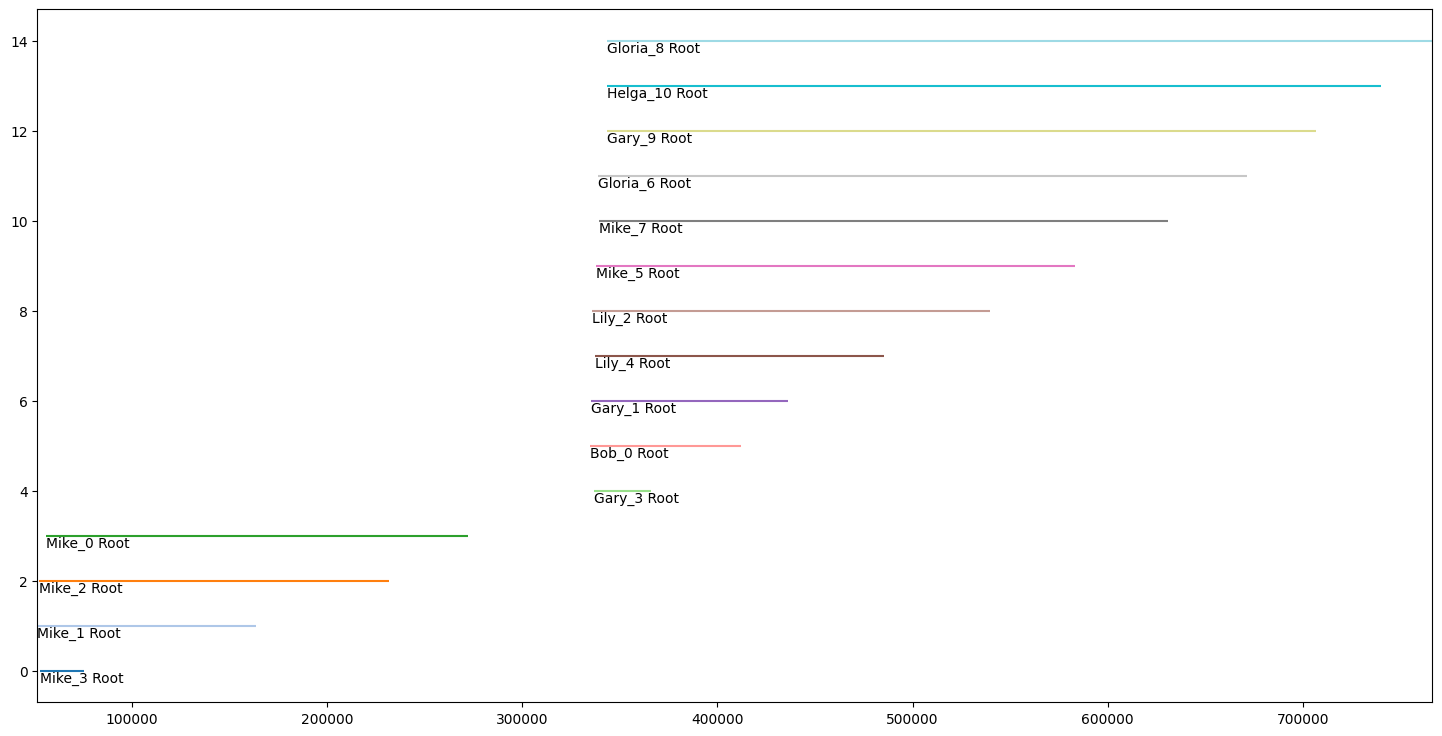

In [82]:

# For each patient, get a timeline of every reference on or before engagement
color_cycler = nu.get_color_cycler(len(patient_engagements_df.patient_id.unique()))
hlineys_list = []
hlinexmins_list = []
hlinexmaxs_list = []
hlinecolors_list = []
hlinelabels_list = []
left_lim = 999999
right_lim = -999999
for (row_index, row_series), (y, face_color_dict) in zip(patient_engagements_df.iterrows(), enumerate(color_cycler())):
    hlineys_list.append(y)
    face_color = face_color_dict['color']
    hlinecolors_list.append(face_color)
    patient_id = row_series.patient_id
    hlinelabels_list.append(patient_id)
    action_tick = row_series.action_tick
    event_time = row_series.event_time
    mask_series = (frvrs_logs_df.patient_id == patient_id)
    mask_series &= (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == 0)
    mask_series &= (frvrs_logs_df.action_tick <= action_tick) & (frvrs_logs_df.event_time <= event_time)
    df = frvrs_logs_df[mask_series].sort_values(['event_time', 'action_tick'])
    if (patient_id == 'Gary_3 Root'): gary_df = df.copy()
    xmin = fu.get_scene_start(df)
    hlinexmins_list.append(xmin)
    if xmin < left_lim: left_lim = xmin
    xmax = df.action_tick.max()
    hlinexmaxs_list.append(xmax)
    if xmax > right_lim: right_lim = xmax
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
ax.set_xlim(left_lim, right_lim)
line_collection_obj = ax.hlines(hlineys_list, hlinexmins_list, hlinexmaxs_list, colors=hlinecolors_list)
for label, x, y in zip(hlinelabels_list, hlinexmins_list, hlineys_list):
    plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, -8), ha='left')


When the *PATIENT_DEMOTED* type action happens, it means only that the status of a patient has changed. This happens when the scene first loads and the initial patient status is calculated. Over time, of the patient is not attended to, the status will degrade and the PATIENT_DEMOTED metric is issued.

In [90]:

# Display the shortest timeline (Gary_3 Root's)
# mask_series = (gary_df.action_type == 'PATIENT_DEMOTED')
mask_series = gary_df.action_type.isin([
    'PATIENT_ENGAGED', 'INJURY_TREATED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
])
action_tick = fu.get_scene_start(gary_df[mask_series])
event_time = gary_df[mask_series].event_time.min()
mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == 0)
mask_series &= (frvrs_logs_df.action_tick <= action_tick) & (frvrs_logs_df.event_time <= event_time)
columns_list = [
    'action_type', 'action_tick', 'event_time', 'voice_capture_message', 'voice_command_message', 'patient_demoted_salt',
    'patient_id', 'location_id'
]
display(frvrs_logs_df[mask_series][columns_list].tail(20).dropna(axis='columns', how='all'))

,action_type,action_tick,event_time,voice_capture_message,voice_command_message,patient_id,location_id
11528,S_A_L_T_WALK_IF_CAN,359626,2023-05-16 16:21:00,NaN,NaN,Helga_10 Root,"(2.4, 0.0, 4.1)"
11529,S_A_L_T_WALKED,359626,2023-05-16 16:21:00,NaN,NaN,Helga_10 Root,"(2.4, 0.0, 4.1)"
11530,VOICE_CAPTURE,359774,2023-05-16 16:21:00,wave if you can hear me,NaN,NaN,NaN
11531,VOICE_COMMAND,359774,2023-05-16 16:21:00,NaN,wave if you can,NaN,NaN
11532,S_A_L_T_WAVE_IF_CAN,359775,2023-05-16 16:21:00,NaN,NaN,Gloria_8 Root,"(4.0, 0.0, 2.3)"
11533,S_A_L_T_WAVE_IF_CAN,359775,2023-05-16 16:21:00,NaN,NaN,Helga_10 Root,"(2.3, 0.0, 4.0)"
11534,S_A_L_T_WALK_IF_CAN,359791,2023-05-16 16:21:00,NaN,NaN,Lily_2 Root,"(3.0, 0.0, 4.5)"
11535,S_A_L_T_WALK_IF_CAN,359791,2023-05-16 16:21:00,NaN,NaN,Lily_4 Root,"(1.2, 0.0, 6.2)"
11536,S_A_L_T_WALK_IF_CAN,359791,2023-05-16 16:21:00,NaN,NaN,Mike_5 Root,"(2.7, 0.0, 2.3)"
11537,S_A_L_T_WALK_IF_CAN,359791,2023-05-16 16:21:00,NaN,NaN,Gloria_6 Root,"(-1.2, 0.0, 3.1)"


In [96]:

columns_list = [
    'action_type', 'action_tick', 'event_time', 'voice_capture_message', 'voice_command_message',
    'patient_demoted_salt', 'patient_id', 'location_id'
]
mask_series = (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
for (session_uuid, patient_id), patient_df in frvrs_logs_df[mask_series].sort_values(['event_time', 'action_tick']).groupby([
    'session_uuid', 'patient_id'
]):
    if patient_df.shape[0] > 1:
        for scene_id, scene_df in patient_df.groupby('scene_id'):
            # display(scene_df.dropna(axis='columns', how='all').T)
            mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id)
            action_tick = fu.get_scene_start(scene_df); mask_series &= (frvrs_logs_df.action_tick <= action_tick)
            event_time = scene_df.event_time.min(); mask_series &= (frvrs_logs_df.event_time <= event_time)
            display(frvrs_logs_df[mask_series][columns_list].tail(20).dropna(axis='columns', how='all'))
        break

,action_type,action_tick,event_time,voice_capture_message,voice_command_message,patient_id,location_id
698,VOICE_COMMAND,515895,2023-05-16 15:07:00,NaN,wave if you can,NaN,NaN
699,S_A_L_T_WAVE_IF_CAN,515896,2023-05-16 15:07:00,NaN,NaN,Lily_2 Root,"(3.0, 0.0, 4.5)"
700,S_A_L_T_WAVED,515896,2023-05-16 15:07:00,NaN,NaN,Lily_2 Root,"(3.0, 0.0, 4.5)"
701,S_A_L_T_WAVE_IF_CAN,515896,2023-05-16 15:07:00,NaN,NaN,Lily_4 Root,"(1.2, 0.0, 6.2)"
702,S_A_L_T_WAVED,515896,2023-05-16 15:07:00,NaN,NaN,Lily_4 Root,"(1.2, 0.0, 6.2)"
703,S_A_L_T_WAVE_IF_CAN,515896,2023-05-16 15:07:00,NaN,NaN,Mike_5 Root,"(2.7, 0.0, 2.3)"
704,S_A_L_T_WAVED,515896,2023-05-16 15:07:00,NaN,NaN,Mike_5 Root,"(2.7, 0.0, 2.3)"
705,S_A_L_T_WAVE_IF_CAN,515896,2023-05-16 15:07:00,NaN,NaN,Gloria_6 Root,"(-1.2, 0.0, 3.1)"
706,S_A_L_T_WAVED,515896,2023-05-16 15:07:00,NaN,NaN,Gloria_6 Root,"(-1.2, 0.0, 3.1)"
707,S_A_L_T_WAVE_IF_CAN,515896,2023-05-16 15:07:00,NaN,NaN,Mike_7 Root,"(1.3, 0.0, 3.4)"


,action_type,action_tick,event_time,patient_id,location_id
2737,TOOL_HOVER,1973831,2023-05-16 15:32:00,NaN,NaN
2738,TOOL_HOVER,1973847,2023-05-16 15:32:00,NaN,NaN
2739,TOOL_HOVER,1973864,2023-05-16 15:32:00,NaN,NaN
2740,TOOL_HOVER,1973882,2023-05-16 15:32:00,NaN,NaN
2741,TOOL_HOVER,1974292,2023-05-16 15:32:00,NaN,NaN
2742,TOOL_HOVER,1974299,2023-05-16 15:32:00,NaN,NaN
2743,TOOL_HOVER,1974317,2023-05-16 15:32:00,NaN,NaN
2744,TOOL_HOVER,1974333,2023-05-16 15:32:00,NaN,NaN
2745,TOOL_HOVER,1974352,2023-05-16 15:32:00,NaN,NaN
2746,TOOL_HOVER,1974371,2023-05-16 15:32:00,NaN,NaN


,action_type,action_tick,event_time,voice_capture_message,voice_command_message,patient_id,location_id
4384,TOOL_APPLIED,2895748,2023-05-16 15:47:00,NaN,NaN,NaN,NaN
4385,VOICE_CAPTURE,2901749,2023-05-16 15:47:00,wave,NaN,NaN,NaN
4386,VOICE_COMMAND,2901749,2023-05-16 15:47:00,NaN,wave if you can,NaN,NaN
4387,S_A_L_T_WAVE_IF_CAN,2901751,2023-05-16 15:47:00,NaN,NaN,Lily_2 Root,"(3.0, 0.0, 4.5)"
4388,S_A_L_T_WAVED,2901751,2023-05-16 15:47:00,NaN,NaN,Lily_2 Root,"(3.0, 0.0, 4.5)"
4389,S_A_L_T_WAVE_IF_CAN,2901751,2023-05-16 15:47:00,NaN,NaN,Lily_4 Root,"(1.2, 0.0, 6.2)"
4390,S_A_L_T_WAVED,2901751,2023-05-16 15:47:00,NaN,NaN,Lily_4 Root,"(1.2, 0.0, 6.2)"
4391,S_A_L_T_WAVE_IF_CAN,2901751,2023-05-16 15:47:00,NaN,NaN,Mike_5 Root,"(2.7, 0.0, 2.3)"
4392,S_A_L_T_WAVED,2901751,2023-05-16 15:47:00,NaN,NaN,Mike_5 Root,"(2.7, 0.0, 2.3)"
4393,S_A_L_T_WAVE_IF_CAN,2901751,2023-05-16 15:47:00,NaN,NaN,Gloria_6 Root,"(-1.2, 0.0, 3.1)"


In [18]:

def show_column_items(cn_str):
    for cn in frvrs_logs_df.columns:
        if cn_str in cn:
            uniques_list = [tool for tool in frvrs_logs_df[cn].unique().tolist() if pd.notnull(tool)]
            if 1 < len(uniques_list) < 20:
                print()
                print(cn, '\n\t' + '\n\t'.join(sorted(uniques_list)))

In [19]:

show_column_items('location')


tool_applied_tool_location 
	cath_needle (UnityEngine.GameObject)
	tor_ring (1) (UnityEngine.GameObject)


In [20]:

show_column_items('tool')


tool_hover_type 
	Gauze
	Hemostatic Gauze
	Needle
	Tourniquet

tool_selected_type 
	Gauze
	Hemostatic Gauze
	Needle
	Tourniquet

tool_applied_type 
	Gauze_Dressing
	Gauze_Pack
	Needle
	Tourniquet

tool_applied_attachment_point 
	LChest_Breathe1 (UnityEngine.GameObject)
	LeftArm (UnityEngine.GameObject)
	LeftForeArm (UnityEngine.GameObject)
	LeftLeg (UnityEngine.GameObject)
	LeftUpLeg (UnityEngine.GameObject)
	RChest_Breathe1 (UnityEngine.GameObject)
	RightArm (UnityEngine.GameObject)
	RightForeArm (UnityEngine.GameObject)
	RightLeg (UnityEngine.GameObject)
	RightUpLeg (UnityEngine.GameObject)
	Spine1 (UnityEngine.GameObject)
	skinCollider_BodyCollideLOD (UnityEngine.GameObject)
	skinCollider_BodyGar_LOD (UnityEngine.GameObject)
	skinCollider_BodyLOD (UnityEngine.GameObject)
	skinCollider_Body_LOD (UnityEngine.GameObject)

tool_applied_tool_location 
	cath_needle (UnityEngine.GameObject)
	tor_ring (1) (UnityEngine.GameObject)

tool_applied_data 
	left_chest
	left_underarm
	right_chest


In [21]:

show_column_items('type')


tool_hover_type 
	Gauze
	Hemostatic Gauze
	Needle
	Tourniquet

tool_selected_type 
	Gauze
	Hemostatic Gauze
	Needle
	Tourniquet

tool_applied_type 
	Gauze_Dressing
	Gauze_Pack
	Needle
	Tourniquet

tag_selected_type 
	black
	gray
	green
	red
	yellow

tag_applied_type 
	black
	gray
	green
	red
	yellow

tag_discarded_type 
	black
	gray
	green
	red
	yellow

tool_discarded_type 
	Gauze
	Hemostatic Gauze
	Needle
	Tourniquet


In [22]:

show_column_items('applied')


tool_applied_type 
	Gauze_Dressing
	Gauze_Pack
	Needle
	Tourniquet

tool_applied_attachment_point 
	LChest_Breathe1 (UnityEngine.GameObject)
	LeftArm (UnityEngine.GameObject)
	LeftForeArm (UnityEngine.GameObject)
	LeftLeg (UnityEngine.GameObject)
	LeftUpLeg (UnityEngine.GameObject)
	RChest_Breathe1 (UnityEngine.GameObject)
	RightArm (UnityEngine.GameObject)
	RightForeArm (UnityEngine.GameObject)
	RightLeg (UnityEngine.GameObject)
	RightUpLeg (UnityEngine.GameObject)
	Spine1 (UnityEngine.GameObject)
	skinCollider_BodyCollideLOD (UnityEngine.GameObject)
	skinCollider_BodyGar_LOD (UnityEngine.GameObject)
	skinCollider_BodyLOD (UnityEngine.GameObject)
	skinCollider_Body_LOD (UnityEngine.GameObject)

tool_applied_tool_location 
	cath_needle (UnityEngine.GameObject)
	tor_ring (1) (UnityEngine.GameObject)

tool_applied_data 
	left_chest
	left_underarm
	right_chest
	right_underarm
	tourniquet(Clone) (UnityEngine.GameObject)

tool_applied_sender 
	AppliedDressingGauze
	AppliedPackingGauze
	App

In [ ]:

frvrs_logs_df.tag_applied_patient_id.unique()

In [ ]:

frvrs_logs_df.injury_treated_id.unique()

In [ ]:

frvrs_logs_df.injury_record_id.unique()

In [ ]:

# 'action_type', 
action_types_list = ['VOICE_COMMAND', 'PATIENT_ENGAGED']
columns_list += [cn for cn in frvrs_logs_df.columns if any(map(lambda x: cn.startswith(x.lower()), action_types_list))]
[fn for fn in dir(df) if fn.startswith('to')]

In [ ]:

df.to_csv('../saves/csv/time_group0.csv')


## Game Object References

In [4]:

def investigate_game_object(search_str, columns_list=None):
    '''
    Investigate the presence of search_str and
    make a list of all search_str references
    '''
    if columns_list is None:
        clean_csvs_srs = frvrs_logs_df.applymap(lambda x: search_str in str(x), na_action='ignore').sum()
        columns_list = clean_csvs_srs[clean_csvs_srs != 0].index.tolist()
    sample_mask_series = False
    references_list = []
    for cn in columns_list:
        mask_series = frvrs_logs_df[cn].map(lambda x: search_str in str(x))
        sample_mask_series |= mask_series
        references_list.extend(frvrs_logs_df[mask_series][cn].unique().tolist())
    print(columns_list, set(references_list))
    df = frvrs_logs_df[sample_mask_series].dropna(axis='columns', how='all')
    display(df.sample(4).T.dropna(axis='index', how='all'))


### UnityEngine.GameObject References

In [ ]:

# Investigate the presence of unity engine game objects
investigate_game_object('Unity')


### "Needle" References

In [ ]:

# Investigate the presence of needles
investigate_game_object('Needle')


### "Hemostatic" References

In [ ]:

# Investigate the presence of hemostatic gauze
investigate_game_object('Hemostatic')


### "Tourniquet" References

In [5]:

# Investigate the presence of tourniquets
investigate_game_object('Tourniquet')

['voice_capture_message', 'tool_hover_type', 'tool_selected_type', 'tool_applied_type', 'tool_applied_sender', 'tool_discarded_type'] {'AppliedTourniquet', 'Tourniquet'}


,130324,62796,122496,136150
action_type,TOOL_SELECTED,TOOL_HOVER,TOOL_HOVER,TOOL_HOVER
action_tick,85541,240165,701531,744438
event_time,2023-04-21 09:28:00,2023-05-11 09:36:00,2023-06-07 08:48:00,2023-04-21 11:27:00
session_uuid,87efcdf5-9090-4fa5-afac-25c778924e9a,3817ac9f-7150-46de-80aa-1b376f6c8a62,e072d31f-2592-4c7e-8709-3db1e111240c,8b5e760a-1f1a-4a28-bd8f-768bc5f216c6
file_name,max10,3817ac9f-7150-46de-80aa-1b376f6c8a62,e072d31f-2592-4c7e-8709-3db1e111240c,max13
scene_id,1,1,2,2
tool_hover_type,NaN,Tourniquet,Tourniquet,Tourniquet
tool_hover_count,NaN,998,996,995
tool_selected_type,Tourniquet,NaN,NaN,NaN
tool_selected_count,998,NaN,NaN,NaN


In [22]:

# Investigate the presence of forearms
srs = frvrs_logs_df.applymap(lambda x: 'forearm' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['injury_record_id', 'voice_capture_message', 'injury_treated_id', 'tool_applied_attachment_point']

In [ ]:

# Investigate the presence of hemorrhage control
srs = frvrs_logs_df.applymap(lambda x: str(x) in ['AppliedTourniquet', 'AppliedPackingGauze'], na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list